# Proyecto Final - Juan Antonio Cruz Escobar

## Calibración de cámara

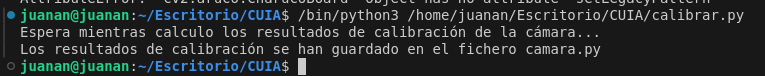

### Código con el que se ha realizado la calibración

In [ ]:
import cv2
import numpy as np
import time

DICCIONARIO = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
tablero = cv2.aruco.CharucoBoard((6, 8), 0.03, 0.02, DICCIONARIO)
tablero.setLegacyPattern(True) #Esto es porque uso un tablaeo de anteriores versiones
detector = cv2.aruco.CharucoDetector(tablero)

# Podemos imprimir creando nosotros la imagen o descargando de...
# https://calib.io/pages/camera-calibration-pattern-generator
#
#paraimprimir = tablero.generateImage((600, 800))
#cv2.imshow("Para Imprimir", paraimprimir)
#cv2.waitKey()
#cv2.imwrite("charuco.tiff", paraimprimir)
#exit()

CPS = 1
esquinas = []
marcadores = []
tiempo = 1.0 / CPS

cap = cv2.VideoCapture(0)
if cap.isOpened():
    wframe = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    hframe = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    final = False
    n = 0
    antes = time.time()
    while not final:
        ret, frame = cap.read()
        if not ret:
            final = True
        else:
            if time.time()-antes > tiempo:
                bboxs, ids, _, _ = detector.detectBoard(frame)
                if ids is not None and ids.size>8:
                        antes = time.time()
                        cv2.aruco.drawDetectedCornersCharuco(frame, bboxs, ids)
                        esquinas.append(bboxs)
                        marcadores.append(ids)
                        n = n + 1
            cv2.putText(frame, str(n), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
            cv2.imshow("WEBCAM", frame)
            if cv2.waitKey(20) > 0:
                final = True
    cap.release()
    cv2.destroyAllWindows()
    if n == 0:
        print("No se han capturado imágenes para hacer la calibración")
    else:
        print("Espera mientras calculo los resultados de calibración de la cámara...")

        cameraMatrixInt = np.array([[ 1000,    0, hframe/2],
                                    [    0, 1000, wframe/2],
                                    [    0,    0,        1]])
        distCoeffsInt = np.zeros((5, 1))
        flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
        (ret, cameraMatrix, distCoeffs, rvec, tvec, stdInt, stdExt, errores) = cv2.aruco.calibrateCameraCharucoExtended(charucoCorners=esquinas,
                                                                                                                charucoIds=marcadores,
                                                                                                                board=tablero,
                                                                                                                imageSize=(hframe, wframe),
                                                                                                                cameraMatrix=cameraMatrixInt,
                                                                                                                distCoeffs=distCoeffsInt,
                                                                                                                flags=flags,
                                                                                                                criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

        with open('camara.py', 'w') as fichero:
            fichero.write("import numpy as np\n")
            fichero.write("cameraMatrix = np.")
            fichero.write(repr(cameraMatrix))
            fichero.write("\ndistCoeffs = np.")
            fichero.write(repr(distCoeffs))
            fichero.close()
            print("Los resultados de calibración se han guardado en el fichero camara.py")
else:
    print("No se pudo abrir la cámara")

### Fichero camara.py resultante

In [ ]:
import numpy as np
cameraMatrix = np.array([[482.29301768,   0.        , 328.55249073],
       [  0.        , 482.29301768, 197.34564483],
       [  0.        ,   0.        ,   1.        ]])
distCoeffs = np.array([[-5.89414432e+00],
       [ 1.05138162e+02],
       [ 5.63950135e-03],
       [ 1.15683573e-04],
       [-2.59941246e+02],
       [-5.87085578e+00],
       [ 1.03910933e+02],
       [-2.56812631e+02],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

## Prueba Deteccion Aruco

Para realizar la prueba de que detecta correctamente nuestro marcador aruco, de primeras vamos a usar el codigo de ejemplo en el que detecta el marcador, dibuja los bordes y pone el ID del mismo

Una vez comprobado el funcionamiento, vamos a usar uno de los ejemplo de los cuadernos Jupyter proporcionados por el profesor.

En este caso vamos a implementar el ejemplo de una imagen rotando sobre el marcador

### Código

In [ ]:
import cv2
import numpy as np
import sys
import os
import time

# Carpeta CUIA
sys.path.append(os.path.join(os.path.dirname(__file__), 'CUIA'))

# Importar el módulo cuia
import cuia
from camara import cameraMatrix, distCoeffs

# Crear el diccionario ArUco y el detector
diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

# Declaramos la cámara que usaremos
cam = 0
# Seleccionamos el mejor backend
bk = cuia.bestBackend(cam)

# Cargamos la imagen que vamos a superponer
baboon = cv2.imread("CUIA/media/baboon.jpg")
imagen = cv2.cvtColor(baboon, cv2.COLOR_BGR2BGRA)  # Convertimos la imagen a BGRA para tener canal de transparencia
h, w, _ = imagen.shape

lado = 0.25 # Tamaño (en metros) del lado de la imagen
vang = 2.0 # Velocidad angular de rotación (en radianes por segundo)

# Definimos un objeto de la clase myVideo para acceder a la cámara seleccionada
ar = cuia.myVideo(cam, bk)

def origen(TAM):
    return np.array([[-TAM/2.0, -TAM/2.0, 0.0],
                     [-TAM/2.0,  TAM/2.0, 0.0],
                     [ TAM/2.0,  TAM/2.0, 0.0],
                     [ TAM/2.0, -TAM/2.0, 0.0]])

def proyeccion(puntos, rvec, tvec, cameraMatrix, distCoeffs):
    puntos_proyectados, _ = cv2.projectPoints(puntos, rvec, tvec, cameraMatrix, distCoeffs)
    return puntos_proyectados.reshape(-1, 2)

# Definimos una función de procesado de frames para dibujar la imagen rotando sobre los marcadores detectados
def imagenrotando(frame):
    framebgra = cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA)
    hframe, wframe, _ = frame.shape
    tam = 0.19 # Tamaño (en metros) del lado del marcador
    bboxs, ids, _ = detector.detectMarkers(frame)
    if ids is not None:
        res = framebgra
        for i in range(len(ids)):
            if ids[i] == 5:  # Solo mostrar la imagen para el marcador con ID 5
                ret, rvec, tvec = cv2.solvePnP(origen(tam), bboxs[i], cameraMatrix, distCoeffs) 
                if ret:
                    t = time.time()
                    # Establecemos las esquinas de un cuadrado vertical a 5cm sobre el marcador
                    esquinas = np.array([[lado/2*np.sin(t*vang), lado/2*np.cos(t*vang), 0.05 + lado],
                                         [lado/2*np.sin(np.pi+t*vang), lado/2*np.cos(np.pi+t*vang), 0.05 + lado],
                                         [lado/2*np.sin(np.pi+t*vang), lado/2*np.cos(np.pi+t*vang), 0.05],
                                         [lado/2*np.sin(t*vang), lado/2*np.cos(t*vang), 0.05]])

                    desde = np.array([[0,0],[w,0],[w,h],[0,h]])                    
                    hasta = proyeccion(esquinas, rvec, tvec, cameraMatrix, distCoeffs)

                    # Para saber si estamos viendo la parte frontal del cuadrado necesitamos calcular el signo del ángulo
                    # de 2 lados adyacentes mediante el producto vectorial
                    v1 = hasta[1] - hasta[0]
                    v2 = hasta[2] - hasta[0]

                    if np.cross(v1, v2) > 0.0:
                        visible = True
                    else:
                        visible = False

                    if visible:
                        M = cv2.getPerspectiveTransform(np.float32(desde), np.float32(hasta))
                        warp = cv2.warpPerspective(imagen, M, dsize=(wframe, hframe))
                        res = cuia.alphaBlending(warp, res)
                    else:  # La cara trasera la pintamos de gris
                        cv2.fillPoly(res, [hasta.astype(int)], color=(40, 40, 40), lineType=cv2.LINE_AA)
    else:
        res = frame
    return res

ar.process = imagenrotando
try:
    ar.play("Imagen rotando", key=ord(' '))
finally:
    ar.release()


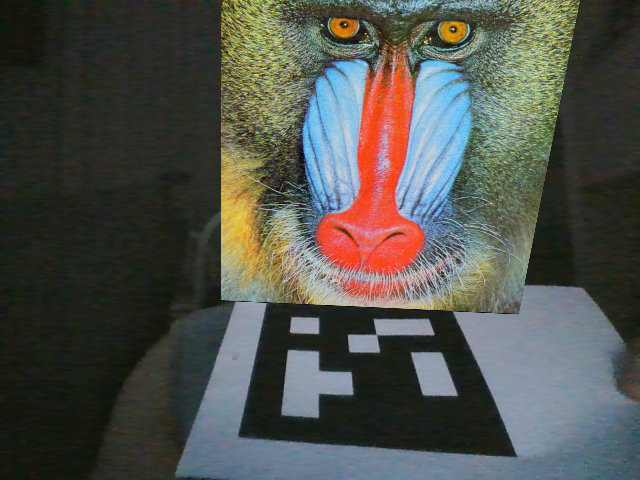


## Renderizado objetos 3D

### Prueba con modelo 3D proporcionado por el profesor

#### Código utilizado:

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import sys
import os

# Asegurarse de que la carpeta CUIA esté en el path de búsqueda
sys.path.append(os.path.join(os.path.dirname(__file__), 'CUIA'))
import cuia
import camara

# Función para convertir las coordenadas de OpenCV a Pyrender
def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3,3] = tvec.T
    pose[0:3,0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1,2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

# Crear la escena con luz ambiental blanca y fondo negro
escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=(1.0, 1.0, 1.0))

# Cargar el modelo 3D
nombrefi = "CUIA/media/cubo.glb"
with open(nombrefi, 'rb') as f:
    modelo_trimesh = trimesh.load(f, file_type='glb')
modelo_mesh = pyrender.Mesh.from_trimesh(list(modelo_trimesh.geometry.values()))

# Matrices de transformación
mat_loc = mathutils.Matrix.Translation((0.0, 0.0, 0.05))
mat_rot = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')
mat_sca = mathutils.Matrix.Scale(1.0, 4)
meshpose = mat_loc @ mat_rot @ mat_sca

# Añadir el modelo a la escena
modelo = pyrender.Node(mesh=modelo_mesh, matrix=np.array(meshpose))
escena.add_node(modelo)

# Obtener los parámetros intrínsecos de la cámara
fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

# Crear la cámara en pyrender y añadirla a la escena
camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

# Seleccionamos el mejor backend y la cámara
camId = 0
bk = cuia.bestBackend(camId)
ar = cuia.myVideo(camId, bk)

# Obtener las dimensiones del frame
hframe = ar.get(cv2.CAP_PROP_FRAME_HEIGHT)
wframe = ar.get(cv2.CAP_PROP_FRAME_WIDTH)

# Configurar el renderizador
mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR) # Convertimos la imagen de color al espacio BGR

    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY) # Umbralizamos la matriz de profundidad poniendo a cero los valores negativos y el resto a uno
    m = (m*255).astype(np.uint8) # Para usarla como canal alfa necesitamos expresarla en el rango [0,255] como números enteros
    m = np.stack((m,m,m), axis=2) # Creamos una imagen de 3 bandas repitiendo la máscara obtenida

    # A continuación empleamos la máscara y su inversa para combinar la imagen del frame con la imagen generada por el render
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

def detectarPose(frame, idMarcador, tam):
    bboxs, ids, rechazados = detector.detectMarkers(frame)
    if ids is not None:
        for i in range(len(ids)):
            if ids[i] == idMarcador:
                objPoints = np.array([[-tam/2.0, tam/2.0, 0.0],
                                      [tam/2.0, tam/2.0, 0.0],
                                      [tam/2.0, -tam/2.0, 0.0],
                                      [-tam/2.0, -tam/2.0, 0.0]])
                ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                if ret:
                    return (True, rvec, tvec)
    return (False, None, None)

def mostrarModelo(frame):
    ret, rvec, tvec = detectarPose(frame, 5, 0.20) # Buscaremos el marcador 5 impreso con 20cm de lado //Comprobar cm 
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec) # Determinamos la posición de la cámara en forma de matriz de transformación de Pyrender
        escena.set_pose(cam, poseCamara) # Ubicamos la cámara en la posición obtenida
        frame = realidadMixta(mirender, frame, escena) # Mezclamos mundo real y mundo virtual
    return frame

ar.process = mostrarModelo
try:
    ar.play("AR", key=ord(' '))
finally:
    ar.release()


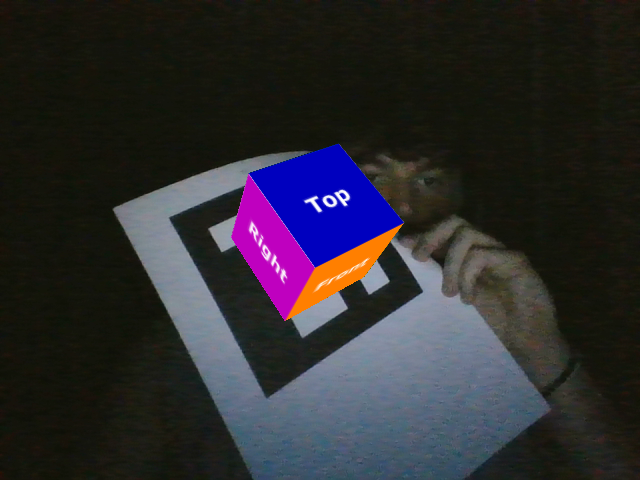

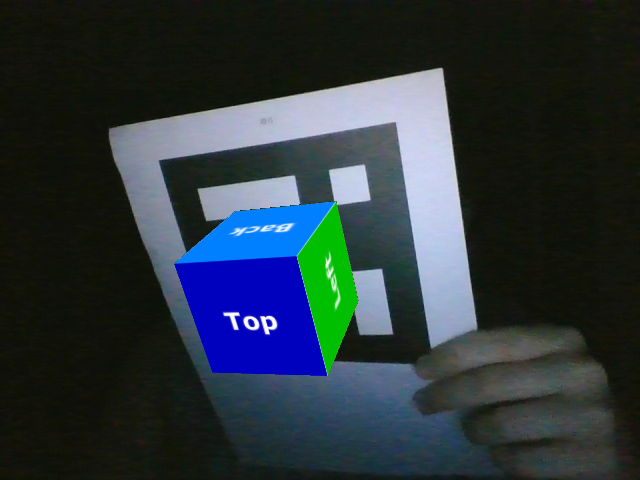

### Descarga modelos 3D para el proyecto final

Usando Sketchfab vamos a descargar dos modelos 3D para nuestro proyecto:

https://skfb.ly/ooQyR

https://skfb.ly/oSVBL

#### Código

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import sys
import os

# Asegurarse de que la carpeta CUIA esté en el path de búsqueda
sys.path.append(os.path.join(os.path.dirname(__file__), 'CUIA'))
import cuia
import camara

# Función para convertir las coordenadas de OpenCV a Pyrender
def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3,3] = tvec.T
    pose[0:3,0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1,2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

# Crear la escena con luz ambiental blanca y fondo negro
escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=(1.0, 1.0, 1.0))

# Cargar el modelo del coche 3D
nombrefi_coche = "src/3D/aston_martin_f1_amr23_2023.glb"
with open(nombrefi_coche, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Matrices de transformación para el coche
mat_loc_coche = mathutils.Matrix.Translation((0.0, 0.0, 0.01))  # Posición del coche
mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')  # Rotar 90 grados en el eje X
mat_rot_coche_z = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'Z')  # Ajustar la rotación del coche en el eje Z según sea necesario
mat_sca_coche = mathutils.Matrix.Scale(0.05, 4)  # Escalado del coche
meshpose_coche = mat_loc_coche @ mat_rot_coche_x @ mat_rot_coche_z @ mat_sca_coche

# Añadir el modelo del coche a la escena
modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
escena.add_node(modelo_coche)

# Obtener los parámetros intrínsecos de la cámara
fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

# Crear la cámara en pyrender y añadirla a la escena
camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

# Seleccionamos el mejor backend y la cámara
camId = 0
bk = cuia.bestBackend(camId)
ar = cuia.myVideo(camId, bk)

# Obtener las dimensiones del frame
hframe = ar.get(cv2.CAP_PROP_FRAME_HEIGHT)
wframe = ar.get(cv2.CAP_PROP_FRAME_WIDTH)

# Configurar el renderizador
mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)  # Convertimos la imagen de color al espacio BGR

    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)  # Umbralizamos la matriz de profundidad poniendo a cero los valores negativos y el resto a uno
    m = (m*255).astype(np.uint8)  # Para usarla como canal alfa necesitamos expresarla en el rango [0,255] como números enteros
    m = np.stack((m, m, m), axis=2)  # Creamos una imagen de 3 bandas repitiendo la máscara obtenida

    # A continuación empleamos la máscara y su inversa para combinar la imagen del frame con la imagen generada por el render
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

def detectarPose(frame, idMarcador, tam):
    bboxs, ids, rechazados = detector.detectMarkers(frame)
    if ids is not None:
        for i in range(len(ids)):
            if ids[i] == idMarcador:
                objPoints = np.array([[-tam/2.0, tam/2.0, 0.0],
                                      [tam/2.0, tam/2.0, 0.0],
                                      [tam/2.0, -tam/2.0, 0.0],
                                      [-tam/2.0, -tam/2.0, 0.0]])
                ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                if ret:
                    return (True, rvec, tvec)
    return (False, None, None)

def mostrarModelo(frame):
    ret, rvec, tvec = detectarPose(frame, 5, 0.20)  # Buscaremos el marcador 5 impreso con 20cm de lado
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)  # Determinamos la posición de la cámara en forma de matriz de transformación de Pyrender
        escena.set_pose(cam, poseCamara)  # Ubicamos la cámara en la posición obtenida
        frame = realidadMixta(mirender, frame, escena)  # Mezclamos mundo real y mundo virtual
    return frame

ar.process = mostrarModelo
try:
    ar.play("AR", key=ord(' '))
finally:
    ar.release()


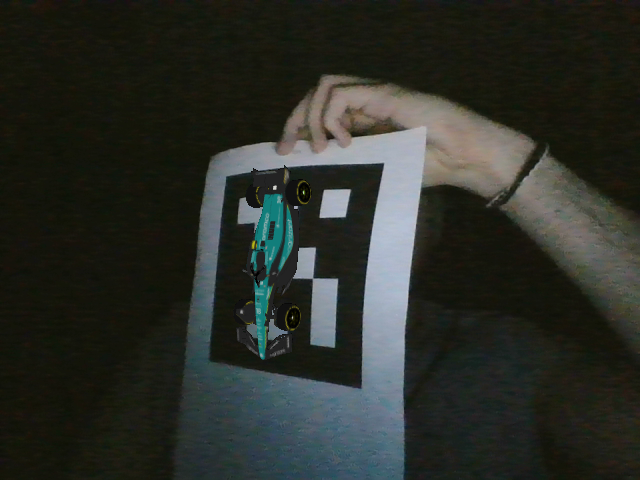

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import sys
import os

# Asegurarse de que la carpeta CUIA esté en el path de búsqueda
sys.path.append(os.path.join(os.path.dirname(__file__), 'CUIA'))
import cuia
import camara

# Función para convertir las coordenadas de OpenCV a Pyrender
def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3,3] = tvec.T
    pose[0:3,0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1,2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

# Crear la escena con luz ambiental blanca y fondo negro
escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=(1.0, 1.0, 1.0))

# Cargar el modelo del circuito 3D
nombrefi_circuito = "src/3D/track.glb"
with open(nombrefi_circuito, 'rb') as f:
    modelo_circuito_trimesh = trimesh.load(f, file_type='glb')
modelo_circuito_mesh = pyrender.Mesh.from_trimesh(list(modelo_circuito_trimesh.geometry.values()))

# Ajustar la escala y orientación del circuito
escala_circuito = 0.00005  # Tamaño del circuito
mat_loc_circuito = mathutils.Matrix.Translation((0.0, 0.0, 0.0))  # Posición inicial del circuito
mat_rot_circuito = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')  # Rotar 90 grados en el eje X para alinear con el marcador
mat_sca_circuito = mathutils.Matrix.Scale(escala_circuito, 4)  # Ajustar la escala del circuito
meshpose_circuito = mat_loc_circuito @ mat_rot_circuito @ mat_sca_circuito

# Añadir el modelo del circuito a la escena
modelo_circuito = pyrender.Node(mesh=modelo_circuito_mesh, matrix=np.array(meshpose_circuito))
escena.add_node(modelo_circuito)

# Cargar el modelo del coche 3D
nombrefi_coche = "src/3D/aston_martin_f1_amr23_2023.glb"
with open(nombrefi_coche, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Matrices de transformación para el coche
mat_loc_coche = mathutils.Matrix.Translation((0.015, 0.0, 0.01))  # Posición del coche
mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')  # Rotar 90 grados en el eje X
mat_rot_coche_z = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'Z')  # Ajustar la rotación del coche en el eje Z según sea necesario
mat_sca_coche = mathutils.Matrix.Scale(0.015, 4)  # Escalado del coche
meshpose_coche = mat_loc_coche @ mat_rot_coche_x @ mat_rot_coche_z @ mat_sca_coche

# Añadir el modelo del coche a la escena
modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
escena.add_node(modelo_coche)

# Obtener los parámetros intrínsecos de la cámara
fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

# Crear la cámara en pyrender y añadirla a la escena
camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

# Seleccionamos el mejor backend y la cámara
camId = 0
bk = cuia.bestBackend(camId)
ar = cuia.myVideo(camId, bk)

# Obtener las dimensiones del frame
hframe = ar.get(cv2.CAP_PROP_FRAME_HEIGHT)
wframe = ar.get(cv2.CAP_PROP_FRAME_WIDTH)

# Configurar el renderizador
mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)  # Convertimos la imagen de color al espacio BGR

    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)  # Umbralizamos la matriz de profundidad poniendo a cero los valores negativos y el resto a uno
    m = (m*255).astype(np.uint8)  # Para usarla como canal alfa necesitamos expresarla en el rango [0,255] como números enteros
    m = np.stack((m, m, m), axis=2)  # Creamos una imagen de 3 bandas repitiendo la máscara obtenida

    # A continuación empleamos la máscara y su inversa para combinar la imagen del frame con la imagen generada por el render
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

def detectarPose(frame, idMarcador, tam):
    bboxs, ids, rechazados = detector.detectMarkers(frame)
    if ids is not None:
        for i in range(len(ids)):
            if ids[i] == idMarcador:
                objPoints = np.array([[-tam/2.0, tam/2.0, 0.0],
                                      [tam/2.0, tam/2.0, 0.0],
                                      [tam/2.0, -tam/2.0, 0.0],
                                      [-tam/2.0, -tam/2.0, 0.0]])
                ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                if ret:
                    return (True, rvec, tvec)
    return (False, None, None)

def mostrarModelo(frame):
    ret, rvec, tvec = detectarPose(frame, 5, 0.20)  # Buscaremos el marcador 5 impreso con 20cm de lado
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)  # Determinamos la posición de la cámara en forma de matriz de transformación de Pyrender
        escena.set_pose(cam, poseCamara)  # Ubicamos la cámara en la posición obtenida
        frame = realidadMixta(mirender, frame, escena)  # Mezclamos mundo real y mundo virtual
    return frame

ar.process = mostrarModelo
try:
    ar.play("AR", key=ord(' '))
finally:
    ar.release()


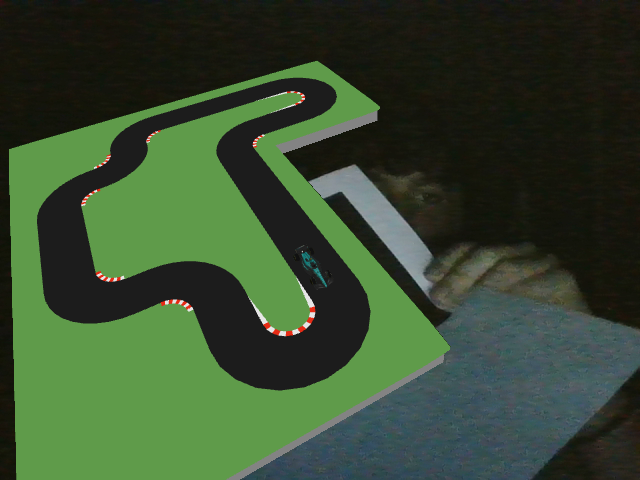

## Creación de matriz de 0 y 1 para representar el circuito

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import sys
import os

# Asegurarse de que la carpeta CUIA esté en el path de búsqueda
sys.path.append(os.path.join(os.path.dirname(__file__), 'CUIA'))
import cuia
import camara

# Función para convertir las coordenadas de OpenCV a Pyrender
def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3, 3] = tvec.T
    pose[0:3, 0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1, 2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

# Crear la escena con luz ambiental blanca y fondo negro
escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=(1.0, 1.0, 1.0))

# Definir manualmente la matriz del circuito en forma de "O"
matrix_size = 300  # Tamaño de la matriz para mayor resolución
circuito = np.zeros((matrix_size, matrix_size), dtype=np.uint8)

# Dibujar el trazado del circuito en forma de "O"
cv2.circle(circuito, (matrix_size // 2, matrix_size // 2), matrix_size // 3, 1, thickness=20)

# Cargar las texturas
textura_tierra = cv2.imread('src/textura/tierra.jpg', cv2.IMREAD_COLOR)
textura_asfalto = cv2.imread('src/textura/asfalto.jpg', cv2.IMREAD_COLOR)

# Redimensionar las texturas al tamaño de la matriz del circuito
textura_tierra = cv2.resize(textura_tierra, (matrix_size, matrix_size))
textura_asfalto = cv2.resize(textura_asfalto, (matrix_size, matrix_size))

# Crear la textura del circuito combinando las imágenes
circuito_texture = np.where(circuito[..., None] == 1, textura_asfalto, textura_tierra)

# Convertir la textura a formato RGBA
circuito_texture_rgba = cv2.cvtColor(circuito_texture, cv2.COLOR_BGR2RGBA)

# Crear una malla plana con la textura del circuito
vertices = np.array([
    [-0.5, -0.5, 0.0],
    [0.5, -0.5, 0.0],
    [0.5, 0.5, 0.0],
    [-0.5, 0.5, 0.0]
])
faces = np.array([[0, 1, 2], [2, 3, 0]])
texture_coords = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0]
])

# Crear la malla
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
visual = trimesh.visual.texture.TextureVisuals(uv=texture_coords, image=circuito_texture_rgba)
mesh.visual = visual

modelo_circuito_mesh = pyrender.Mesh.from_trimesh(mesh)

# Ajustar la escala y orientación del circuito
escala_circuito = 1.5  # Aumentar la escala del circuito
mat_loc_circuito = mathutils.Matrix.Translation((0.0, 0.0, -0.02))  # Posición inicial del circuito (debajo del coche)
mat_rot_circuito = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'X')  # Mantener el plano horizontal
mat_sca_circuito = mathutils.Matrix.Scale(escala_circuito, 4)  # Ajustar la escala del circuito
meshpose_circuito = mat_loc_circuito @ mat_rot_circuito @ mat_sca_circuito

# Añadir el modelo del circuito a la escena
modelo_circuito = pyrender.Node(mesh=modelo_circuito_mesh, matrix=np.array(meshpose_circuito))
escena.add_node(modelo_circuito)

# Cargar el modelo del coche 3D
nombrefi_coche = "src/3D/aston_martin_f1_amr23_2023.glb"
with open(nombrefi_coche, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Matrices de transformación para el coche
mat_loc_coche = mathutils.Matrix.Translation((0.0, 0.0, 0.01))  # Posición del coche
mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')  # Rotar 90 grados en el eje X
mat_rot_coche_z = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'Z')  # Ajustar la rotación del coche en el eje Z según sea necesario
mat_sca_coche = mathutils.Matrix.Scale(0.015, 4)  # Escalado del coche
meshpose_coche = mat_loc_coche @ mat_rot_coche_x @ mat_rot_coche_z @ mat_sca_coche

# Añadir el modelo del coche a la escena
modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
escena.add_node(modelo_coche)

# Obtener los parámetros intrínsecos de la cámara
fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

# Crear la cámara en pyrender y añadirla a la escena
camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

# Seleccionamos el mejor backend y la cámara
camId = 0
bk = cuia.bestBackend(camId)
ar = cuia.myVideo(camId, bk)

# Obtener las dimensiones del frame
hframe = ar.get(cv2.CAP_PROP_FRAME_HEIGHT)
wframe = ar.get(cv2.CAP_PROP_FRAME_WIDTH)

# Configurar el renderizador
mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)  # Convertimos la imagen de color al espacio BGR

    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)  # Umbralizamos la matriz de profundidad poniendo a cero los valores negativos y el resto a uno
    m = (m * 255).astype(np.uint8)  # Para usarla como canal alfa necesitamos expresarla en el rango [0, 255] como números enteros
    m = np.stack((m, m, m), axis=2)  # Creamos una imagen de 3 bandas repitiendo la máscara obtenida

    # A continuación empleamos la máscara y su inversa para combinar la imagen del frame con la imagen generada por el render
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

def detectarPose(frame, idMarcador, tam):
    bboxs, ids, rechazados = detector.detectMarkers(frame)
    if ids is not None:
        for i in range(len(ids)):
            if ids[i] == idMarcador:
                objPoints = np.array([[-tam / 2.0, tam / 2.0, 0.0],
                                      [tam / 2.0, tam / 2.0, 0.0],
                                      [tam / 2.0, -tam / 2.0, 0.0],
                                      [-tam / 2.0, -tam / 2.0, 0.0]])
                ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                if ret:
                    return (True, rvec, tvec)
    return (False, None, None)

def mostrarModelo(frame):
    ret, rvec, tvec = detectarPose(frame, 5, 0.15)  # Buscaremos el marcador 5 impreso con 15cm de lado
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)  # Determinamos la posición de la cámara en forma de matriz de transformación de Pyrender
        escena.set_pose(cam, poseCamara)  # Ubicamos la cámara en la posición obtenida
        frame = realidadMixta(mirender, frame, escena)  # Mezclamos mundo real y mundo virtual
    return frame

ar.process = mostrarModelo
try:
    ar.play("AR", key=ord(' '))
finally:
    ar.release()


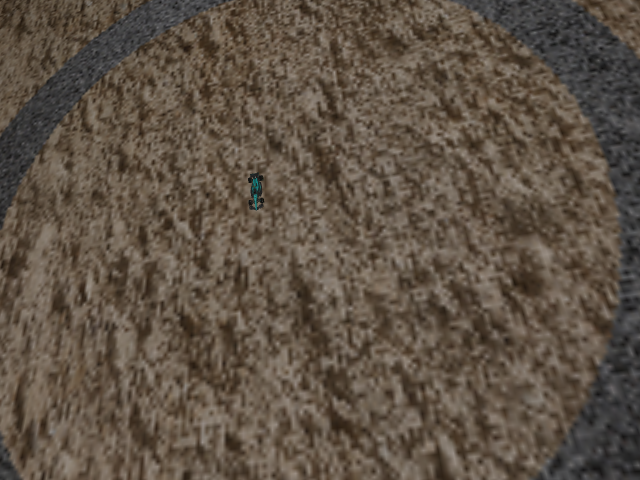

## Utilización del segundo marcador para girar el coche

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import sys
import os

# Asegurarse de que la carpeta CUIA esté en el path de búsqueda
sys.path.append(os.path.join(os.path.dirname(__file__), 'CUIA'))
import cuia
import camara

# Función para convertir las coordenadas de OpenCV a Pyrender
def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3, 3] = tvec.T
    pose[0:3, 0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1, 2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

# Crear la escena con luz ambiental blanca y fondo negro
escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=(1.0, 1.0, 1.0))

# Definir manualmente la matriz del circuito en forma de "O"
matrix_size = 150  # Tamaño de la matriz para mayor resolución
circuito = np.zeros((matrix_size, matrix_size), dtype=np.uint8)

# Dibujar el trazado del circuito en forma de "O"
cv2.circle(circuito, (matrix_size // 2, matrix_size // 2), matrix_size // 3, 1, thickness=20)

# Cargar las texturas
textura_tierra = cv2.imread('src/textura/tierra.jpg', cv2.IMREAD_COLOR)
textura_asfalto = cv2.imread('src/textura/asfalto.jpg', cv2.IMREAD_COLOR)

# Redimensionar las texturas al tamaño de la matriz del circuito
textura_tierra = cv2.resize(textura_tierra, (matrix_size, matrix_size))
textura_asfalto = cv2.resize(textura_asfalto, (matrix_size, matrix_size))

# Crear la textura del circuito combinando las imágenes
circuito_texture = np.where(circuito[..., None] == 1, textura_asfalto, textura_tierra)

# Convertir la textura a formato RGBA
circuito_texture_rgba = cv2.cvtColor(circuito_texture, cv2.COLOR_BGR2RGBA)

# Crear una malla plana con la textura del circuito
vertices = np.array([
    [-0.5, -0.5, 0.0],
    [0.5, -0.5, 0.0],
    [0.5, 0.5, 0.0],
    [-0.5, 0.5, 0.0]
])
faces = np.array([[0, 1, 2], [2, 3, 0]])
texture_coords = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0]
])

# Crear la malla
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
visual = trimesh.visual.texture.TextureVisuals(uv=texture_coords, image=circuito_texture_rgba)
mesh.visual = visual

modelo_circuito_mesh = pyrender.Mesh.from_trimesh(mesh)

# Ajustar la escala y orientación del circuito
escala_circuito = 1.5  # Aumentar la escala del circuito
mat_loc_circuito = mathutils.Matrix.Translation((0.0, 0.0, -0.02))  # Posición inicial del circuito (debajo del coche)
mat_rot_circuito = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'X')  # Mantener el plano horizontal
mat_sca_circuito = mathutils.Matrix.Scale(escala_circuito, 4)  # Ajustar la escala del circuito
meshpose_circuito = mat_loc_circuito @ mat_rot_circuito @ mat_sca_circuito

# Añadir el modelo del circuito a la escena
modelo_circuito = pyrender.Node(mesh=modelo_circuito_mesh, matrix=np.array(meshpose_circuito))
escena.add_node(modelo_circuito)

# Cargar el modelo del coche 3D
nombrefi_coche = "src/3D/aston_martin_f1_amr23_2023.glb"
with open(nombrefi_coche, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Matrices de transformación para el coche
mat_loc_coche = mathutils.Matrix.Translation((0.0, 0.0, 0.01))  # Posición del coche
mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')  # Rotar 90 grados en el eje X
mat_rot_coche_z = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'Z')  # Ajustar la rotación del coche en el eje Z según sea necesario
mat_sca_coche = mathutils.Matrix.Scale(0.015, 4)  # Escalado del coche
meshpose_coche = mat_loc_coche @ mat_rot_coche_x @ mat_rot_coche_z @ mat_sca_coche

# Añadir el modelo del coche a la escena
modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
escena.add_node(modelo_coche)

# Obtener los parámetros intrínsecos de la cámara
fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

# Crear la cámara en pyrender y añadirla a la escena
camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

# Seleccionamos el mejor backend y la cámara
camId = 0
bk = cuia.bestBackend(camId)
ar = cuia.myVideo(camId, bk)

# Obtener las dimensiones del frame
hframe = ar.get(cv2.CAP_PROP_FRAME_HEIGHT)
wframe = ar.get(cv2.CAP_PROP_FRAME_WIDTH)

# Configurar el renderizador
mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)  # Convertimos la imagen de color al espacio BGR

    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)  # Umbralizamos la matriz de profundidad poniendo a cero los valores negativos y el resto a uno
    m = (m * 255).astype(np.uint8)  # Para usarla como canal alfa necesitamos expresarla en el rango [0, 255] como números enteros
    m = np.stack((m, m, m), axis=2)  # Creamos una imagen de 3 bandas repitiendo la máscara obtenida

    # A continuación empleamos la máscara y su inversa para combinar la imagen del frame con la imagen generada por el render
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

# Variable para almacenar la rotación del coche
rot_coche = 0.0

def detectarPose(frame, idMarcador, tam):
    bboxs, ids, rechazados = detector.detectMarkers(frame)
    if ids is not None:
        for i in range(len(ids)):
            if ids[i] == idMarcador:
                objPoints = np.array([[-tam / 2.0, tam / 2.0, 0.0],
                                      [tam / 2.0, tam / 2.0, 0.0],
                                      [tam / 2.0, -tam / 2.0, 0.0],
                                      [-tam / 2.0, -tam / 2.0, 0.0]])
                ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                if ret:
                    return (True, rvec, tvec)
    return (False, None, None)

def mostrarModelo(frame):
    global rot_coche
    ret, rvec, tvec = detectarPose(frame, 5, 0.15)  # Buscaremos el marcador 5 impreso con 15cm de lado
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)  # Determinamos la posición de la cámara en forma de matriz de transformación de Pyrender
        escena.set_pose(cam, poseCamara)  # Ubicamos la cámara en la posición obtenida

    ret, rvec, tvec = detectarPose(frame, 6, 0.15)  # Buscaremos el marcador 6 impreso con 15cm de lado
    if ret:
        # Obtener el ángulo de rotación del marcador
        rmat = cv2.Rodrigues(rvec)[0]
        angle = math.atan2(rmat[1, 0], rmat[0, 0])  # Obtener el ángulo alrededor del eje 
        rot_coche = angle

    # Aplicar la rotación al coche
    mat_rot_coche_z = mathutils.Matrix.Rotation(rot_coche, 4, 'Y')
    meshpose_coche = mat_loc_coche @ mat_rot_coche_x @ mat_rot_coche_z @ mat_sca_coche
    escena.set_pose(modelo_coche, np.array(meshpose_coche))

    frame = realidadMixta(mirender, frame, escena)  # Mezclamos mundo real y mundo virtual
    return frame

ar.process = mostrarModelo
try:
    ar.play("AR", key=ord(' '))
finally:
    ar.release()


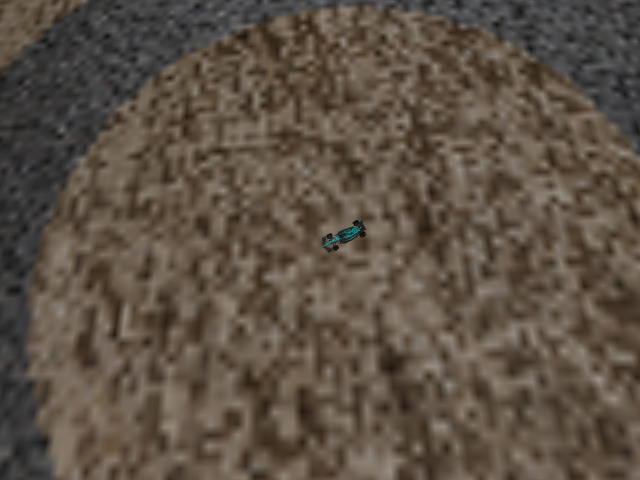

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import sys
import os

# Asegurarse de que la carpeta CUIA esté en el path de búsqueda
sys.path.append(os.path.join(os.path.dirname(__file__), 'CUIA'))
import cuia
import camara

# Función para convertir las coordenadas de OpenCV a Pyrender
def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3, 3] = tvec.T
    pose[0:3, 0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1, 2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

# Crear la escena con luz ambiental blanca y fondo negro
escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=(1.0, 1.0, 1.0))

# Definir manualmente la matriz del circuito en forma de "O"
matrix_size = 150  # Tamaño de la matriz para mayor resolución
circuito = np.zeros((matrix_size, matrix_size), dtype=np.uint8)

# Dibujar el trazado del circuito en forma de "O"
cv2.circle(circuito, (matrix_size // 2, matrix_size // 2), matrix_size // 3, 1, thickness=20)

# Cargar las texturas
textura_tierra = cv2.imread('src/textura/tierra.jpg', cv2.IMREAD_COLOR)
textura_asfalto = cv2.imread('src/textura/asfalto.jpg', cv2.IMREAD_COLOR)

# Redimensionar las texturas al tamaño de la matriz del circuito
textura_tierra = cv2.resize(textura_tierra, (matrix_size, matrix_size))
textura_asfalto = cv2.resize(textura_asfalto, (matrix_size, matrix_size))

# Crear la textura del circuito combinando las imágenes
circuito_texture = np.where(circuito[..., None] == 1, textura_asfalto, textura_tierra)

# Convertir la textura a formato RGBA
circuito_texture_rgba = cv2.cvtColor(circuito_texture, cv2.COLOR_BGR2RGBA)

# Crear una malla plana con la textura del circuito
vertices = np.array([
    [-0.5, -0.5, 0.0],
    [0.5, -0.5, 0.0],
    [0.5, 0.5, 0.0],
    [-0.5, 0.5, 0.0]
])
faces = np.array([[0, 1, 2], [2, 3, 0]])
texture_coords = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0]
])

# Crear la malla
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
visual = trimesh.visual.texture.TextureVisuals(uv=texture_coords, image=circuito_texture_rgba)
mesh.visual = visual

modelo_circuito_mesh = pyrender.Mesh.from_trimesh(mesh)

# Ajustar la escala y orientación del circuito
escala_circuito = 1.5  # Aumentar la escala del circuito
mat_loc_circuito = mathutils.Matrix.Translation((0.0, 0.0, -0.02))  # Posición inicial del circuito (debajo del coche)
mat_rot_circuito = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'X')  # Mantener el plano horizontal
mat_sca_circuito = mathutils.Matrix.Scale(escala_circuito, 4)  # Ajustar la escala del circuito
meshpose_circuito = mat_loc_circuito @ mat_rot_circuito @ mat_sca_circuito

# Añadir el modelo del circuito a la escena
modelo_circuito = pyrender.Node(mesh=modelo_circuito_mesh, matrix=np.array(meshpose_circuito))
escena.add_node(modelo_circuito)

# Cargar el modelo del coche 3D
nombrefi_coche = "src/3D/aston_martin_f1_amr23_2023.glb"
with open(nombrefi_coche, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Matrices de transformación para el coche
mat_loc_coche = mathutils.Matrix.Translation((0.5, 0.0, 0.01))  # Posición del coche
mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')  # Rotar 90 grados en el eje X
mat_rot_coche_z = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'Z')  # Ajustar la rotación del coche en el eje Z según sea necesario
mat_sca_coche = mathutils.Matrix.Scale(0.025, 4)  # Escalado del coche
meshpose_coche = mat_loc_coche @ mat_rot_coche_x @ mat_rot_coche_z @ mat_sca_coche

# Añadir el modelo del coche a la escena
modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
escena.add_node(modelo_coche)

# Obtener los parámetros intrínsecos de la cámara
fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

# Crear la cámara en pyrender y añadirla a la escena
camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

# Seleccionamos el mejor backend y la cámara
camId = 0
bk = cuia.bestBackend(camId)
ar = cuia.myVideo(camId, bk)

# Obtener las dimensiones del frame
hframe = ar.get(cv2.CAP_PROP_FRAME_HEIGHT)
wframe = ar.get(cv2.CAP_PROP_FRAME_WIDTH)

# Configurar el renderizador
mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)  # Convertimos la imagen de color al espacio BGR

    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)  # Umbralizamos la matriz de profundidad poniendo a cero los valores negativos y el resto a uno
    m = (m * 255).astype(np.uint8)  # Para usarla como canal alfa necesitamos expresarla en el rango [0, 255] como números enteros
    m = np.stack((m, m, m), axis=2)  # Creamos una imagen de 3 bandas repitiendo la máscara obtenida

    # A continuación empleamos la máscara y su inversa para combinar la imagen del frame con la imagen generada por el render
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

# Variable para almacenar la rotación del coche
rot_coche = 0.0

def detectarPose(frame, idMarcador, tam):
    bboxs, ids, rechazados = detector.detectMarkers(frame)
    if ids is not None:
        for i in range(len(ids)):
            if ids[i] == idMarcador:
                objPoints = np.array([[-tam / 2.0, tam / 2.0, 0.0],
                                      [tam / 2.0, tam / 2.0, 0.0],
                                      [tam / 2.0, -tam / 2.0, 0.0],
                                      [-tam / 2.0, -tam / 2.0, 0.0]])
                ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                if ret:
                    return (True, rvec, tvec)
    return (False, None, None)

def mostrarModelo(frame):
    global rot_coche
    ret, rvec, tvec = detectarPose(frame, 5, 0.15)  # Buscaremos el marcador 5 impreso con 15cm de lado
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)  # Determinamos la posición de la cámara en forma de matriz de transformación de Pyrender
        escena.set_pose(cam, poseCamara)  # Ubicamos la cámara en la posición obtenida

    ret, rvec, tvec = detectarPose(frame, 6, 0.15)  # Buscaremos el marcador 6 impreso con 15cm de lado
    if ret:
        # Obtener el ángulo de rotación del marcador
        rmat = cv2.Rodrigues(rvec)[0]
        angle = math.atan2(rmat[1, 0], rmat[0, 0])  # Obtener el ángulo alrededor del eje 
        rot_coche = angle

    # Aplicar la rotación al coche
    mat_rot_coche_z = mathutils.Matrix.Rotation(rot_coche, 4, 'Y')
    meshpose_coche = mat_loc_coche @ mat_rot_coche_x @ mat_rot_coche_z @ mat_sca_coche
    escena.set_pose(modelo_coche, np.array(meshpose_coche))

    frame = realidadMixta(mirender, frame, escena)  # Mezclamos mundo real y mundo virtual
    return frame

ar.process = mostrarModelo
try:
    ar.play("AR", key=ord(' '))
finally:
    ar.release()


## Implementar movimiento del coche sobre la matriz

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import cuia
import camara

def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3, 3] = tvec.T
    pose[0:3, 0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1, 2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=(1.0, 1.0, 1.0))
matrix_size = 150
circuito = np.zeros((matrix_size, matrix_size), dtype=np.uint8)
cv2.circle(circuito, (matrix_size // 2, matrix_size // 2), matrix_size // 3, 1, thickness=20)

textura_tierra = cv2.imread('src/textura/tierra.jpg', cv2.IMREAD_COLOR)
textura_asfalto = cv2.imread('src/textura/asfalto.jpg', cv2.IMREAD_COLOR)
textura_tierra = cv2.resize(textura_tierra, (matrix_size, matrix_size))
textura_asfalto = cv2.resize(textura_asfalto, (matrix_size, matrix_size))

circuito_texture = np.where(circuito[..., None] == 1, textura_asfalto, textura_tierra)
circuito_texture_rgba = cv2.cvtColor(circuito_texture, cv2.COLOR_BGR2RGBA)

vertices = np.array([
    [-0.5, -0.5, 0.0],
    [0.5, -0.5, 0.0],
    [0.5, 0.5, 0.0],
    [-0.5, 0.5, 0.0]
])
faces = np.array([[0, 1, 2], [2, 3, 0]])
texture_coords = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0]
])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
visual = trimesh.visual.texture.TextureVisuals(uv=texture_coords, image=circuito_texture_rgba)
mesh.visual = visual

modelo_circuito_mesh = pyrender.Mesh.from_trimesh(mesh)

escala_circuito = 1.5
mat_loc_circuito = mathutils.Matrix.Translation((0.0, 0.0, -0.02))
mat_rot_circuito = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'X')
mat_sca_circuito = mathutils.Matrix.Scale(escala_circuito, 4)
meshpose_circuito = mat_loc_circuito @ mat_rot_circuito @ mat_sca_circuito

modelo_circuito = pyrender.Node(mesh=modelo_circuito_mesh, matrix=np.array(meshpose_circuito))
escena.add_node(modelo_circuito)

nombrefi_coche = "src/3D/aston_martin_f1_amr23_2023.glb"
with open(nombrefi_coche, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Definir la posición inicial del coche
initial_pos_world = (0.5, 0.0, 0.01)
mat_loc_coche = mathutils.Matrix.Translation(initial_pos_world)
mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')
mat_rot_coche_y = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'Y')
mat_sca_coche = mathutils.Matrix.Scale(0.025, 4)
meshpose_coche = mat_loc_coche @ mat_rot_coche_x @ mat_rot_coche_y @ mat_sca_coche

modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
escena.add_node(modelo_coche)

fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

camId = 0
bk = cuia.bestBackend(camId)
ar = cuia.myVideo(camId, bk)

hframe = int(ar.get(cv2.CAP_PROP_FRAME_HEIGHT))
wframe = int(ar.get(cv2.CAP_PROP_FRAME_WIDTH))

mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)
    m = (m * 255).astype(np.uint8)
    m = np.stack((m, m, m), axis=2)
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

rot_coche = 0.0
pos_coche = np.array(initial_pos_world[:2])  # Solo las coordenadas x, y
velocidad_coche = 0.0030  # Velocidad del coche

def detectarPose(frame, idMarcador, tam):
    bboxs, ids, rechazados = detector.detectMarkers(frame)
    if ids is not None:
        for i in range(len(ids)):
            if ids[i] == idMarcador:
                objPoints = np.array([[-tam / 2.0, tam / 2.0, 0.0],
                                      [tam / 2.0, tam / 2.0, 0.0],
                                      [tam / 2.0, -tam / 2.0, 0.0],
                                      [-tam / 2.0, -tam / 2.0, 0.0]])
                ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                if ret:
                    return (True, rvec, tvec)
    return (False, None, None)

def mostrarModelo(frame):
    global rot_coche, pos_coche
    ret, rvec, tvec = detectarPose(frame, 5, 0.15)
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)
        escena.set_pose(cam, poseCamara)

    ret, rvec, tvec = detectarPose(frame, 6, 0.15)
    if ret:
        rmat = cv2.Rodrigues(rvec)[0]
        angle = math.atan2(rmat[1, 0], rmat[0, 0])
        rot_coche = angle

    # Crear matriz de rotación 2D para la orientación del coche
    rot_matrix = np.array([
        [math.cos(rot_coche), -math.sin(rot_coche)],
        [math.sin(rot_coche), math.cos(rot_coche)]
    ])

    # Mover el coche hacia adelante en su sistema de coordenadas locales
    movement_vector = np.array([0, -velocidad_coche])  # Hacia adelante (sur) en el sistema de coordenadas del coche
    pos_coche += rot_matrix @ movement_vector

    mat_loc_coche = mathutils.Matrix.Translation((pos_coche[0], pos_coche[1], initial_pos_world[2]))
    mat_rot_coche_y = mathutils.Matrix.Rotation(rot_coche, 4, 'Y')
    meshpose_coche = mat_loc_coche @ mat_rot_coche_x @ mat_rot_coche_y @ mat_sca_coche
    escena.set_pose(modelo_coche, np.array(meshpose_coche))

    frame = realidadMixta(mirender, frame, escena)
    return frame

ar.process = mostrarModelo
try:
    ar.play("AR", key=ord(' '))
finally:
    ar.release()


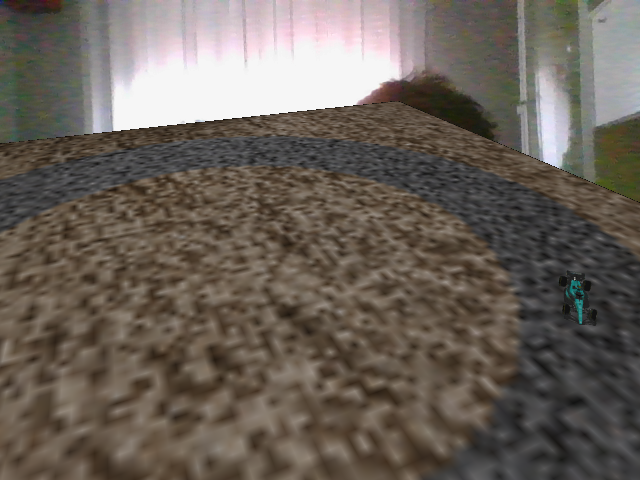

Actualmente, no se esta teniendo en cuenta si el coche esta pasando sobre un 0 o un 1, por lo que podemos conducir por la "tierra".

Vamos a intentar solucionar esto

## Hacer que si nos salimos del circuito, el coche vuelva a la posición incial

Ahora debemos implementar la logica para que si detecta que el coche esta fuera del asfalto, vuelva a su posicion inicial

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import cuia
import camara

def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3, 3] = tvec.T
    pose[0:3, 0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1, 2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=(1.0, 1.0, 1.0))
matrix_size = 150
circuito = np.zeros((matrix_size, matrix_size), dtype=np.uint8)
cv2.circle(circuito, (matrix_size // 2, matrix_size // 2), matrix_size // 3, 1, thickness=20)

textura_tierra = cv2.imread('src/textura/tierra.jpg', cv2.IMREAD_COLOR)
textura_asfalto = cv2.imread('src/textura/asfalto.jpg', cv2.IMREAD_COLOR)
textura_tierra = cv2.resize(textura_tierra, (matrix_size, matrix_size))
textura_asfalto = cv2.resize(textura_asfalto, (matrix_size, matrix_size))

circuito_texture = np.where(circuito[..., None] == 1, textura_asfalto, textura_tierra)
circuito_texture_rgba = cv2.cvtColor(circuito_texture, cv2.COLOR_BGR2RGBA)

vertices = np.array([
    [-0.5, -0.5, 0.0],
    [0.5, -0.5, 0.0],
    [0.5, 0.5, 0.0],
    [-0.5, 0.5, 0.0]
])
faces = np.array([[0, 1, 2], [2, 3, 0]])
texture_coords = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0]
])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
visual = trimesh.visual.texture.TextureVisuals(uv=texture_coords, image=circuito_texture_rgba)
mesh.visual = visual

modelo_circuito_mesh = pyrender.Mesh.from_trimesh(mesh)

escala_circuito = 1
mat_loc_circuito = mathutils.Matrix.Translation((0.0, 0.0, -0.02))
mat_rot_circuito = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'X')
mat_sca_circuito = mathutils.Matrix.Scale(escala_circuito, 4)
meshpose_circuito = mat_loc_circuito @ mat_rot_circuito @ mat_sca_circuito

modelo_circuito = pyrender.Node(mesh=modelo_circuito_mesh, matrix=np.array(meshpose_circuito))
escena.add_node(modelo_circuito)

nombrefi_coche = "src/3D/aston_martin_f1_amr23_2023.glb"
with open(nombrefi_coche, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Definir la posición inicial del coche
initial_pos_world = (0.30, 0.0, 0.01)
mat_loc_coche = mathutils.Matrix.Translation(initial_pos_world)
mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')
mat_rot_coche_y = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'Y')
mat_sca_coche = mathutils.Matrix.Scale(0.025, 4)
meshpose_coche = mat_loc_coche @ mat_rot_coche_x @ mat_rot_coche_y @ mat_sca_coche

modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
escena.add_node(modelo_coche)

fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

camId = 0
bk = cuia.bestBackend(camId)
ar = cuia.myVideo(camId, bk)

hframe = int(ar.get(cv2.CAP_PROP_FRAME_HEIGHT))
wframe = int(ar.get(cv2.CAP_PROP_FRAME_WIDTH))

mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)
    m = (m * 255).astype(np.uint8)
    m = np.stack((m, m, m), axis=2)
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

rot_coche = 0.0
pos_coche = np.array(initial_pos_world[:2])  # Solo las coordenadas x, y
velocidad_coche = 0.0030  # Velocidad del coche

def detectarPose(frame, idMarcador, tam):
    bboxs, ids, rechazados = detector.detectMarkers(frame)
    if ids is not None:
        for i in range(len(ids)):
            if ids[i] == idMarcador:
                objPoints = np.array([[-tam / 2.0, tam / 2.0, 0.0],
                                      [tam / 2.0, tam / 2.0, 0.0],
                                      [tam / 2.0, -tam / 2.0, 0.0],
                                      [-tam / 2.0, -tam / 2.0, 0.0]])
                ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                if ret:
                    return (True, rvec, tvec)
    return (False, None, None)

def verificarSuperficie(pos_coche, circuito, matrix_size):
    # Convertir la posición del coche a coordenadas de la matriz del circuito
    matrix_x = int((pos_coche[0] + 0.5) * matrix_size)
    matrix_y = int((pos_coche[1] + 0.5) * matrix_size)
    
    # Asegurarse de que las coordenadas estén dentro de los límites de la matriz
    if 0 <= matrix_x < matrix_size and 0 <= matrix_y < matrix_size:
        # Devolver el valor de la matriz del circuito en esa posición
        return circuito[matrix_y, matrix_x], matrix_x, matrix_y
    else:
        # Devolver un valor por defecto si la posición está fuera de los límites
        return -1, matrix_x, matrix_y

def mostrarModelo(frame):
    global rot_coche, pos_coche
    ret, rvec, tvec = detectarPose(frame, 5, 0.15)
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)
        escena.set_pose(cam, poseCamara)

    ret, rvec, tvec = detectarPose(frame, 6, 0.15)
    if ret:
        rmat = cv2.Rodrigues(rvec)[0]
        angle = math.atan2(rmat[1, 0], rmat[0, 0])
        rot_coche = angle

    # Crear matriz de rotación 2D para la orientación del coche
    rot_matrix = np.array([
        [math.cos(rot_coche), -math.sin(rot_coche)],
        [math.sin(rot_coche), math.cos(rot_coche)]
    ])

    # Mover el coche hacia adelante en su sistema de coordenadas locales
    movement_vector = np.array([0, -velocidad_coche])  # Hacia adelante (sur) en el sistema de coordenadas del coche
    pos_coche += rot_matrix @ movement_vector

    # Verificar la superficie debajo del coche
    superficie, matrix_x, matrix_y = verificarSuperficie(pos_coche, circuito, matrix_size)
    if superficie == 1:
        print(f"El coche está sobre el asfalto en posición ({matrix_x}, {matrix_y})")
    elif superficie == 0:
        print(f"El coche está sobre la tierra en posición ({matrix_x}, {matrix_y})")
        # Reiniciar posición del coche a la posición inicial
        pos_coche = np.array(initial_pos_world[:2])
        rot_coche = 0.0  # Opcionalmente reiniciar la rotación
    else:
        print(f"El coche está fuera del circuito en posición ({matrix_x}, {matrix_y})")

    mat_loc_coche = mathutils.Matrix.Translation((pos_coche[0], pos_coche[1], initial_pos_world[2]))
    mat_rot_coche_y = mathutils.Matrix.Rotation(rot_coche, 4, 'Y')
    meshpose_coche = mat_loc_coche @ mat_rot_coche_x @ mat_rot_coche_y @ mat_sca_coche
    escena.set_pose(modelo_coche, np.array(meshpose_coche))

    frame = realidadMixta(mirender, frame, escena)
    return frame

ar.process = mostrarModelo
try:
    ar.play("AR", key=ord(' '))
finally:
    ar.release()



## Acceso a Cámara IP

Descargamos Droidcam en nuestro telefono movil, este sera el encargado de el render tanto del circuito como del coche.

La camara del portatil se encargara de la conduccion del coche.

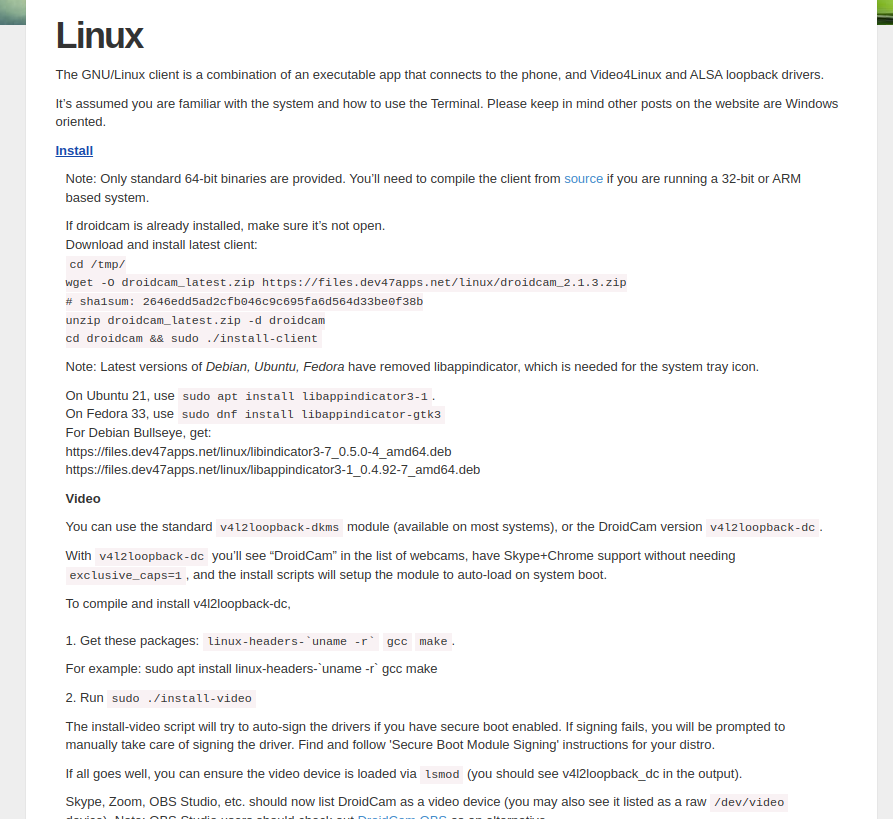

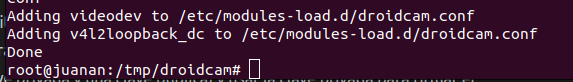

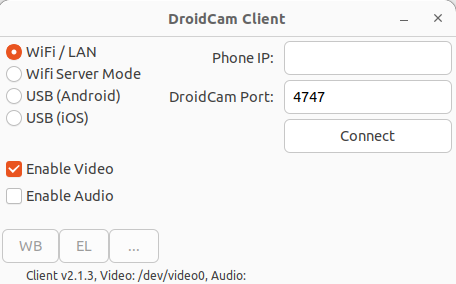

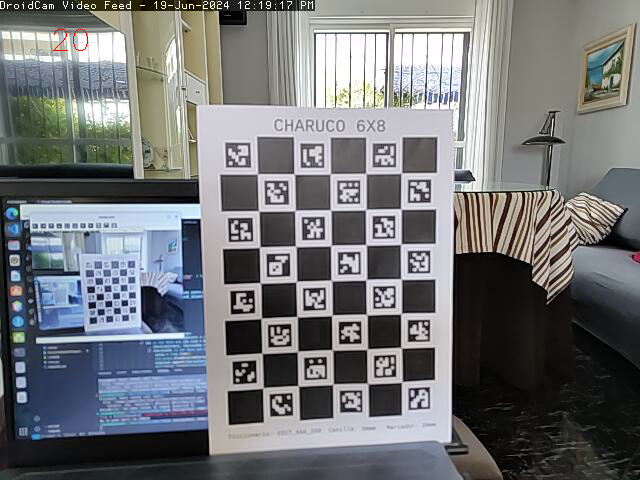

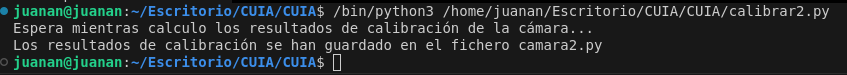

### Código calibracion Camara 2 

In [ ]:
import cv2
import numpy as np
import time

DICCIONARIO = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
tablero = cv2.aruco.CharucoBoard((6, 8), 0.03, 0.02, DICCIONARIO)
tablero.setLegacyPattern(True)  # Esto es porque uso un tablero de versiones anteriores

# Podemos imprimir creando nosotros la imagen o descargando de...
# https://calib.io/pages/camera-calibration-pattern-generator
#
# paraimprimir = tablero.generateImage((600, 800))
# cv2.imshow("Para Imprimir", paraimprimir)
# cv2.waitKey()
# cv2.imwrite("charuco.tiff", paraimprimir)
# exit()

CPS = 1
esquinas = []
marcadores = []
tiempo = 1.0 / CPS

# Configurar la cámara de DroidCam
ipcam_url = "http://192.168.1.147:4747/video"  # Reemplazar con la URL de DroidCam
cap = cv2.VideoCapture(ipcam_url)

if cap.isOpened():
    wframe = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    hframe = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    final = False
    n = 0
    antes = time.time()
    while not final:
        ret, frame = cap.read()
        if not ret:
            final = True
        else:
            if time.time() - antes > tiempo:
                corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame, DICCIONARIO)
                if ids is not None and ids.size > 8:
                    _, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(corners, ids, frame, tablero)
                    if charucoIds is not None and charucoIds.size > 8:
                        antes = time.time()
                        cv2.aruco.drawDetectedCornersCharuco(frame, charucoCorners, charucoIds)
                        esquinas.append(charucoCorners)
                        marcadores.append(charucoIds)
                        n += 1
            cv2.putText(frame, str(n), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255))
            cv2.imshow("WEBCAM", frame)
            if cv2.waitKey(20) > 0:
                final = True
    cap.release()
    cv2.destroyAllWindows()
    if n == 0:
        print("No se han capturado imágenes para hacer la calibración")
    else:
        print("Espera mientras calculo los resultados de calibración de la cámara...")

        cameraMatrixInt = np.array([[1000, 0, hframe / 2],
                                    [0, 1000, wframe / 2],
                                    [0, 0, 1]])
        distCoeffsInt = np.zeros((5, 1))
        flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
        (ret, cameraMatrix, distCoeffs, rvec, tvec, stdInt, stdExt, errores) = cv2.aruco.calibrateCameraCharucoExtended(
            charucoCorners=esquinas,
            charucoIds=marcadores,
            board=tablero,
            imageSize=(hframe, wframe),
            cameraMatrix=cameraMatrixInt,
            distCoeffs=distCoeffsInt,
            flags=flags,
            criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

        with open('camara2.py', 'w') as fichero:
            fichero.write("import numpy as np\n")
            fichero.write("cameraMatrix = np.")
            fichero.write(repr(cameraMatrix))
            fichero.write("\ndistCoeffs = np.")
            fichero.write(repr(distCoeffs))
            fichero.close()
            print("Los resultados de calibración se han guardado en el fichero camara2.py")
else:
    print("No se pudo abrir la cámara")


### Fichero camara2.py resultante

In [ ]:
import numpy as np
cameraMatrix = np.array([[458.02227551,   0.        , 327.32290737],
       [  0.        , 458.02227551, 249.06760641],
       [  0.        ,   0.        ,   1.        ]])
distCoeffs = np.array([[ 4.97489201e+00],
       [ 6.44916793e+01],
       [ 2.85128507e-03],
       [ 3.24121488e-03],
       [-3.26496858e+01],
       [ 4.71989579e+00],
       [ 6.42277515e+01],
       [-3.44524417e+01],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

## Implementacion en distintos ficheros de lo realizado hasta ahora

### main.py

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import cuia
import camara2 as camara
from control import CarControl

def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3, 3] = tvec.T
    pose[0:3, 0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1, 2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=(1.0, 1.0, 1.0))
matrix_size = 150
circuito = np.zeros((matrix_size, matrix_size), dtype=np.uint8)
cv2.circle(circuito, (matrix_size // 2, matrix_size // 2), matrix_size // 3, 1, thickness=20)

textura_tierra = cv2.imread('src/textura/tierra.jpg', cv2.IMREAD_COLOR)
textura_asfalto = cv2.imread('src/textura/asfalto.jpg', cv2.IMREAD_COLOR)
textura_tierra = cv2.resize(textura_tierra, (matrix_size, matrix_size))
textura_asfalto = cv2.resize(textura_asfalto, (matrix_size, matrix_size))

circuito_texture = np.where(circuito[..., None] == 1, textura_asfalto, textura_tierra)
circuito_texture_rgba = cv2.cvtColor(circuito_texture, cv2.COLOR_BGR2RGBA)

vertices = np.array([
    [-0.5, -0.5, 0.0],
    [0.5, -0.5, 0.0],
    [0.5, 0.5, 0.0],
    [-0.5, 0.5, 0.0]
])
faces = np.array([[0, 1, 2], [2, 3, 0]])
texture_coords = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0]
])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
visual = trimesh.visual.texture.TextureVisuals(uv=texture_coords, image=circuito_texture_rgba)
mesh.visual = visual

modelo_circuito_mesh = pyrender.Mesh.from_trimesh(mesh)

escala_circuito = 1
mat_loc_circuito = mathutils.Matrix.Translation((0.0, 0.0, -0.02))
mat_rot_circuito = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'X')
mat_sca_circuito = mathutils.Matrix.Scale(escala_circuito, 4)
meshpose_circuito = mat_loc_circuito @ mat_rot_circuito @ mat_sca_circuito

modelo_circuito = pyrender.Node(mesh=modelo_circuito_mesh, matrix=np.array(meshpose_circuito))
escena.add_node(modelo_circuito)

nombrefi_coche = "src/3D/aston_martin_f1_amr23_2023.glb"
with open(nombrefi_coche, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Definir la posición inicial del coche
initial_pos_world = (0.30, 0.0, 0.01)

# Crear instancia de CarControl
car_control = CarControl(initial_pos_world, 0.0030)

# Inicializar modelo del coche después de capturar el primer frame
first_frame_captured = False

fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

# Configura la URL de la cámara IP de DroidCam
droidcam_url = "http://192.168.1.147:4747/video"
cap = cv2.VideoCapture(droidcam_url)

if not cap.isOpened():
    print("Error: No se puede abrir la cámara IP")
    exit()

hframe = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
wframe = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)
    m = (m * 255).astype(np.uint8)
    m = np.stack((m, m, m), axis=2)
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

def mostrarModelo(frame):
    ret, rvec, tvec = car_control.detectarPose(frame, 5, 0.15)
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)
        escena.set_pose(cam, poseCamara)

    # Actualizar la posición del coche
    meshpose_coche = car_control.actualizarPosicion(circuito, matrix_size)
    escena.set_pose(modelo_coche, np.array(meshpose_coche))

    frame = realidadMixta(mirender, frame, escena)
    return frame

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Capturar el frame de la cámara ID 1 para el control del coche si no se ha hecho aún
    if not first_frame_captured:
        meshpose_coche = car_control.actualizarPosicion(circuito, matrix_size)
        modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
        escena.add_node(modelo_coche)
        first_frame_captured = True

    frame = mostrarModelo(frame)
    cv2.imshow('AR', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
car_control.cap.release()
cv2.destroyAllWindows()


### control.py

In [ ]:
import math
import mathutils
import numpy as np
import cv2
import camara2 as camara

class CarControl:
    def __init__(self, initial_pos_world, velocidad_coche):
        self.rot_coche = 0.0
        self.pos_coche = np.array(initial_pos_world[:2])  # Solo las coordenadas x, y
        self.velocidad_coche = velocidad_coche
        self.initial_pos_world = initial_pos_world

        # Inicializa las matrices de rotación y escala
        self.mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')
        self.mat_sca_coche = mathutils.Matrix.Scale(0.025, 4)

        # Configura la captura de video desde la cámara con ID 1
        self.cap = cv2.VideoCapture(1)
        if not self.cap.isOpened():
            raise ValueError("No se puede abrir la cámara con ID 1")

    def detectarPose(self, frame, idMarcador, tam):
        diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
        detector = cv2.aruco.ArucoDetector(diccionario)
        bboxs, ids, rechazados = detector.detectMarkers(frame)
        if ids is not None:
            for i in range(len(ids)):
                if ids[i] == idMarcador:
                    objPoints = np.array([[-tam / 2.0, tam / 2.0, 0.0],
                                          [tam / 2.0, tam / 2.0, 0.0],
                                          [tam / 2.0, -tam / 2.0, 0.0],
                                          [-tam / 2.0, -tam / 2.0, 0.0]])
                    ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                    if ret:
                        return (True, rvec, tvec)
        return (False, None, None)

    def verificarSuperficie(self, pos_coche, circuito, matrix_size):
        # Convertir la posición del coche a coordenadas de la matriz del circuito
        matrix_x = int((pos_coche[0] + 0.5) * matrix_size)
        matrix_y = int((pos_coche[1] + 0.5) * matrix_size)
        
        # Asegurarse de que las coordenadas estén dentro de los límites de la matriz
        if 0 <= matrix_x < matrix_size and 0 <= matrix_y < matrix_size:
            # Devolver el valor de la matriz del circuito en esa posición
            return circuito[matrix_y, matrix_x], matrix_x, matrix_y
        else:
            # Devolver un valor por defecto si la posición está fuera de los límites
            return -1, matrix_x, matrix_y

    def actualizarPosicion(self, circuito, matrix_size):
        # Capturar el frame de la cámara ID 1
        ret, frame = self.cap.read()
        if not ret:
            raise ValueError("No se puede leer el frame de la cámara ID 1")

        ret, rvec, tvec = self.detectarPose(frame, 6, 0.15)
        if ret:
            rmat = cv2.Rodrigues(rvec)[0]
            angle = math.atan2(rmat[1, 0], rmat[0, 0])
            self.rot_coche = angle

        # Crear matriz de rotación 2D para la orientación del coche
        rot_matrix = np.array([
            [math.cos(self.rot_coche), -math.sin(self.rot_coche)],
            [math.sin(self.rot_coche), math.cos(self.rot_coche)]
        ])

        # Mover el coche hacia adelante en su sistema de coordenadas locales
        movement_vector = np.array([0, -self.velocidad_coche])  # Hacia adelante (sur) en el sistema de coordenadas del coche
        self.pos_coche += rot_matrix @ movement_vector

        # Verificar la superficie debajo del coche
        superficie, matrix_x, matrix_y = self.verificarSuperficie(self.pos_coche, circuito, matrix_size)

        if superficie == 0:
            # Reiniciar posición del coche a la posición inicial
            self.pos_coche = np.array(self.initial_pos_world[:2])
            self.rot_coche = 0.0  # Opcionalmente reiniciar la rotación

        mat_loc_coche = mathutils.Matrix.Translation((self.pos_coche[0], self.pos_coche[1], self.initial_pos_world[2]))
        mat_rot_coche_y = mathutils.Matrix.Rotation(self.rot_coche, 4, 'Y')
        meshpose_coche = mat_loc_coche @ self.mat_rot_coche_x @ mat_rot_coche_y @ self.mat_sca_coche

        return meshpose_coche


## Añadir sonidos con pygame

Vamos a añadir un sonido cuando el coche se este moviendo de un motor.

Ademas, cuando el coche pise tierra, sonara una explosión.

In [ ]:
import math
import mathutils
import numpy as np
import cv2
import camara2 as camara
import pygame

class CarControl:
    def __init__(self, initial_pos_world, velocidad_coche):
        self.rot_coche = 0.0
        self.pos_coche = np.array(initial_pos_world[:2])  # Solo las coordenadas x, y
        self.velocidad_coche = velocidad_coche
        self.initial_pos_world = initial_pos_world

        # Inicializa las matrices de rotación y escala
        self.mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')
        self.mat_sca_coche = mathutils.Matrix.Scale(0.025, 4)

        # Configura la captura de video desde la cámara con ID 1
        self.cap = cv2.VideoCapture(1)
        if not self.cap.isOpened():
            raise ValueError("No se puede abrir la cámara con ID 1")

        # Inicializa pygame y carga el sonido del motor
        pygame.mixer.init()
        self.sound_motor = pygame.mixer.Sound('src/sound/motor.mp3')
        self.sound_motor.set_volume(0.2)  # Ajusta el volumen 
        self.sound_boom = pygame.mixer.Sound('src/sound/explosion.mp3')
        self.sound_boom.set_volume(0.1)  # Ajusta el volumen

    def detectarPose(self, frame, idMarcador, tam):
        diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
        detector = cv2.aruco.ArucoDetector(diccionario)
        bboxs, ids, rechazados = detector.detectMarkers(frame)
        if ids is not None:
            for i in range(len(ids)):
                if ids[i] == idMarcador:
                    objPoints = np.array([[-tam / 2.0, tam / 2.0, 0.0],
                                          [tam / 2.0, tam / 2.0, 0.0],
                                          [tam / 2.0, -tam / 2.0, 0.0],
                                          [-tam / 2.0, -tam / 2.0, 0.0]])
                    ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                    if ret:
                        return (True, rvec, tvec)
        return (False, None, None)

    def verificarSuperficie(self, pos_coche, circuito, matrix_size):
        # Convertir la posición del coche a coordenadas de la matriz del circuito
        matrix_x = int((pos_coche[0] + 0.5) * matrix_size)
        matrix_y = int((pos_coche[1] + 0.5) * matrix_size)
        
        # Asegurarse de que las coordenadas estén dentro de los límites de la matriz
        if 0 <= matrix_x < matrix_size and 0 <= matrix_y < matrix_size:
            # Devolver el valor de la matriz del circuito en esa posición
            return circuito[matrix_y, matrix_x], matrix_x, matrix_y
        else:
            # Devolver un valor por defecto si la posición está fuera de los límites
            return -1, matrix_x, matrix_y

    def actualizarPosicion(self, circuito, matrix_size):
        # Capturar el frame de la cámara ID 1
        ret, frame = self.cap.read()
        if not ret:
            raise ValueError("No se puede leer el frame de la cámara ID 1")

        ret, rvec, tvec = self.detectarPose(frame, 6, 0.15)
        if ret:
            rmat = cv2.Rodrigues(rvec)[0]
            angle = math.atan2(rmat[1, 0], rmat[0, 0])
            self.rot_coche = angle

        # Crear matriz de rotación 2D para la orientación del coche
        rot_matrix = np.array([
            [math.cos(self.rot_coche), -math.sin(self.rot_coche)],
            [math.sin(self.rot_coche), math.cos(self.rot_coche)]
        ])

        # Mover el coche hacia adelante en su sistema de coordenadas locales
        movement_vector = np.array([0, -self.velocidad_coche])  # Hacia adelante (sur) en el sistema de coordenadas del coche
        self.pos_coche += rot_matrix @ movement_vector

        # Reproducir sonido de motor si el coche se está moviendo
        if not pygame.mixer.get_busy():
            self.sound_motor.play(-1)  # -1 para repetir el sonido en loop

        # Verificar la superficie debajo del coche
        superficie, matrix_x, matrix_y = self.verificarSuperficie(self.pos_coche, circuito, matrix_size)

        if superficie == 0:
            # Reiniciar posición del coche a la posición inicial
            self.pos_coche = np.array(self.initial_pos_world[:2])
            self.rot_coche = 0.0  # Reiniciar la rotación
            pygame.mixer.stop()  # Detener el sonido si el coche se reinicia
            self.sound_boom.play()  # Reproducir el sonido de colisión

        mat_loc_coche = mathutils.Matrix.Translation((self.pos_coche[0], self.pos_coche[1], self.initial_pos_world[2]))
        mat_rot_coche_y = mathutils.Matrix.Rotation(self.rot_coche, 4, 'Y')
        meshpose_coche = mat_loc_coche @ self.mat_rot_coche_x @ mat_rot_coche_y @ self.mat_sca_coche

        return meshpose_coche


## Añadir consciencia de contexto

Para añadir consciencia de contexto, vamos a hacer que dependiendo de la hora del dia, cargue un modelo de coche u otro.

Además se cambiara la iluminacion de la escena.

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import cuia
import camara2 as camara
from control import CarControl
from datetime import datetime

def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3, 3] = tvec.T
    pose[0:3, 0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1, 2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

# Obtener la hora actual del sistema
current_hour = datetime.now().hour

# Definir el modelo de coche y la luz ambiental según la hora
if 8 <= current_hour < 14:
    coche_model_path = "src/3D/aston_martin_f1_amr23_2023.glb" #Aston martin si la hora es entre las 8 y las 14
    ambient_light = (1.0, 1.0, 1.0)  # Luz brillante
else:
    coche_model_path = "src/3D/oracle_red_bull_f1_car_rb19_2023.glb" # RedBull para las horas restantes
    ambient_light = (0.2, 0.2, 0.2)  # Luz más oscura

# Crear la escena con la luz ambiental ajustada
escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=ambient_light)
matrix_size = 150
circuito = np.zeros((matrix_size, matrix_size), dtype=np.uint8)
cv2.circle(circuito, (matrix_size // 2, matrix_size // 2), matrix_size // 3, 1, thickness=20)

textura_tierra = cv2.imread('src/textura/tierra.jpg', cv2.IMREAD_COLOR)
textura_asfalto = cv2.imread('src/textura/asfalto.jpg', cv2.IMREAD_COLOR)
textura_tierra = cv2.resize(textura_tierra, (matrix_size, matrix_size))
textura_asfalto = cv2.resize(textura_asfalto, (matrix_size, matrix_size))

circuito_texture = np.where(circuito[..., None] == 1, textura_asfalto, textura_tierra)
circuito_texture_rgba = cv2.cvtColor(circuito_texture, cv2.COLOR_BGR2RGBA)

vertices = np.array([
    [-0.5, -0.5, 0.0],
    [0.5, -0.5, 0.0],
    [0.5, 0.5, 0.0],
    [-0.5, 0.5, 0.0]
])
faces = np.array([[0, 1, 2], [2, 3, 0]])
texture_coords = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0]
])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
visual = trimesh.visual.texture.TextureVisuals(uv=texture_coords, image=circuito_texture_rgba)
mesh.visual = visual

modelo_circuito_mesh = pyrender.Mesh.from_trimesh(mesh)

escala_circuito = 1
mat_loc_circuito = mathutils.Matrix.Translation((0.0, 0.0, -0.02))
mat_rot_circuito = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'X')
mat_sca_circuito = mathutils.Matrix.Scale(escala_circuito, 4)
meshpose_circuito = mat_loc_circuito @ mat_rot_circuito @ mat_sca_circuito

modelo_circuito = pyrender.Node(mesh=modelo_circuito_mesh, matrix=np.array(meshpose_circuito))
escena.add_node(modelo_circuito)

# Cargar el modelo del coche según la hora del sistema
with open(coche_model_path, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Definir la posición inicial del coche
initial_pos_world = (0.30, 0.0, 0.01)

# Crear instancia de CarControl
car_control = CarControl(initial_pos_world, 0.0030)

# Inicializar modelo del coche después de capturar el primer frame
first_frame_captured = False

fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

# Configura la URL de la cámara IP de DroidCam
droidcam_url = "http://192.168.1.147:4747/video"
cap = cv2.VideoCapture(droidcam_url)

if not cap.isOpened():
    print("Error: No se puede abrir la cámara IP")
    exit()

hframe = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
wframe = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)
    m = (m * 255).astype(np.uint8)
    m = np.stack((m, m, m), axis=2)
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

def mostrarModelo(frame):
    ret, rvec, tvec = car_control.detectarPose(frame, 5, 0.15)
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)
        escena.set_pose(cam, poseCamara)

    # Actualizar la posición del coche
    meshpose_coche = car_control.actualizarPosicion(circuito, matrix_size)
    escena.set_pose(modelo_coche, np.array(meshpose_coche))

    frame = realidadMixta(mirender, frame, escena)
    return frame

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Capturar el frame de la cámara ID 1 para el control del coche si no se ha hecho aún
    if not first_frame_captured:
        meshpose_coche = car_control.actualizarPosicion(circuito, matrix_size)
        modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
        escena.add_node(modelo_coche)
        first_frame_captured = True

    frame = mostrarModelo(frame)
    cv2.imshow('AR', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
car_control.cap.release()
cv2.destroyAllWindows()


Si la hora está entre las 8 AM y las 2 PM, se carga el modelo del coche de Aston Martin y se crea una luz ambiental brillante.
Si la hora está entre las 2 PM y las 7 AM, se carga el modelo del coche de RedBull y se configura una luz ambiental más oscura.

## Control por voz

Para ello vamos a usar la libreria speech_recognition.

Vamos a crear 4 comando, para arrancar el coche y detenerlo y para aumentar y disminuir la velocidad del mismo. Los comando seran "iniciar", "detener", "acelerar" y "frenar".

### main.py

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import cuia
import camara2 as camara
from control import CarControl
from datetime import datetime
import threading

def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3, 3] = tvec.T
    pose[0:3, 0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1, 2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

# Obtener la hora actual del sistema
current_hour = datetime.now().hour

# Definir el modelo de coche y la luz ambiental según la hora
if 8 <= current_hour < 14:
    coche_model_path = "src/3D/aston_martin_f1_amr23_2023.glb" #Aston martin si la hora es entre las 8 y las 14
    ambient_light = (1.0, 1.0, 1.0)  # Luz brillante
else:
    coche_model_path = "src/3D/oracle_red_bull_f1_car_rb19_2023.glb" # RedBull para las horas restantes
    ambient_light = (0.2, 0.2, 0.2)  # Luz más oscura

# Crear la escena con la luz ambiental ajustada
escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=ambient_light)
matrix_size = 150
circuito = np.zeros((matrix_size, matrix_size), dtype=np.uint8)
cv2.circle(circuito, (matrix_size // 2, matrix_size // 2), matrix_size // 3, 1, thickness=20)

textura_tierra = cv2.imread('src/textura/tierra.jpg', cv2.IMREAD_COLOR)
textura_asfalto = cv2.imread('src/textura/asfalto.jpg', cv2.IMREAD_COLOR)
textura_tierra = cv2.resize(textura_tierra, (matrix_size, matrix_size))
textura_asfalto = cv2.resize(textura_asfalto, (matrix_size, matrix_size))

circuito_texture = np.where(circuito[..., None] == 1, textura_asfalto, textura_tierra)
circuito_texture_rgba = cv2.cvtColor(circuito_texture, cv2.COLOR_BGR2RGBA)

vertices = np.array([
    [-0.5, -0.5, 0.0],
    [0.5, -0.5, 0.0],
    [0.5, 0.5, 0.0],
    [-0.5, 0.5, 0.0]
])
faces = np.array([[0, 1, 2], [2, 3, 0]])
texture_coords = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0]
])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
visual = trimesh.visual.texture.TextureVisuals(uv=texture_coords, image=circuito_texture_rgba)
mesh.visual = visual

modelo_circuito_mesh = pyrender.Mesh.from_trimesh(mesh)

escala_circuito = 1
mat_loc_circuito = mathutils.Matrix.Translation((0.0, 0.0, -0.02))
mat_rot_circuito = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'X')
mat_sca_circuito = mathutils.Matrix.Scale(escala_circuito, 4)
meshpose_circuito = mat_loc_circuito @ mat_rot_circuito @ mat_sca_circuito

modelo_circuito = pyrender.Node(mesh=modelo_circuito_mesh, matrix=np.array(meshpose_circuito))
escena.add_node(modelo_circuito)

# Cargar el modelo del coche según la hora del sistema
with open(coche_model_path, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Definir la posición inicial del coche
initial_pos_world = (0.30, 0.0, 0.001)

# Crear instancia de CarControl
car_control = CarControl(initial_pos_world, 0.0030)

# Inicializar modelo del coche después de capturar el primer frame
first_frame_captured = False

fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

# Configura la URL de la cámara IP de DroidCam
droidcam_url = "http://192.168.1.147:4747/video"
cap = cv2.VideoCapture(droidcam_url)

if not cap.isOpened():
    print("Error: No se puede abrir la cámara IP")
    exit()

hframe = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
wframe = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)
    m = (m * 255).astype(np.uint8)
    m = np.stack((m, m, m), axis=2)
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

def mostrarModelo(frame):
    ret, rvec, tvec = car_control.detectarPose(frame, 5, 0.15)
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)
        escena.set_pose(cam, poseCamara)

    # Actualizar la posición del coche
    meshpose_coche = car_control.actualizarPosicion(circuito, matrix_size)
    escena.set_pose(modelo_coche, np.array(meshpose_coche))

    frame = realidadMixta(mirender, frame, escena)
    return frame

def escuchar_comandos():
    while True:
        car_control.escuchar_comando()

# Iniciar un hilo para escuchar comandos de voz
hilo_voz = threading.Thread(target=escuchar_comandos, daemon=True)
hilo_voz.start()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Capturar el frame de la cámara ID 0 para el control del coche si no se ha hecho aún
    if not first_frame_captured:
        meshpose_coche = car_control.actualizarPosicion(circuito, matrix_size)
        modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
        escena.add_node(modelo_coche)
        first_frame_captured = True

    frame = mostrarModelo(frame)
    cv2.imshow('AR', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
car_control.cap.release()
cv2.destroyAllWindows()


### control.py

In [ ]:
import math
import mathutils
import numpy as np
import cv2
import camara2 as camara
import pygame
import speech_recognition as sr

class CarControl:
    def __init__(self, initial_pos_world, velocidad_coche):
        self.rot_coche = 0.0
        self.pos_coche = np.array(initial_pos_world[:2])  # Solo las coordenadas x, y
        self.velocidad_coche = velocidad_coche
        self.initial_pos_world = initial_pos_world
        self.moving = False  # Para controlar el movimiento del coche

        # Inicializa las matrices de rotación y escala
        self.mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')
        self.mat_sca_coche = mathutils.Matrix.Scale(0.025, 4)

        # Configura la captura de video desde la cámara con ID 0
        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            raise ValueError("No se puede abrir la cámara con ID 0")

        # Inicializa pygame y carga los sonidos
        pygame.mixer.init()
        self.sound_motor = pygame.mixer.Sound('src/sound/motor.mp3')
        self.sound_motor.set_volume(0.2)  # Ajusta el volumen 
        self.sound_boom = pygame.mixer.Sound('src/sound/explosion.mp3')
        self.sound_boom.set_volume(0.1)  # Ajusta el volumen

        # Inicializa el reconocimiento de voz
        self.recognizer = sr.Recognizer()
        self.microphone = sr.Microphone()

    def escuchar_comando(self):
        with self.microphone as source:
            print("Escuchando...")
            self.recognizer.adjust_for_ambient_noise(source)
            audio = self.recognizer.listen(source)

        try:
            comando = self.recognizer.recognize_google(audio, language='es-ES')
            print(f"Comando escuchado: {comando}")
            self.procesar_comando(comando.lower())
        except sr.UnknownValueError:
            print("No se pudo entender el audio")
        except sr.RequestError as e:
            print(f"No se pudo solicitar resultados del servicio de reconocimiento de voz; {e}")

    def procesar_comando(self, comando):
        if "iniciar" in comando:
            self.moving = True
            if not pygame.mixer.get_busy():
                self.sound_motor.play(-1)  # Reproducir sonido del motor en loop
        elif "detener" in comando:
            self.moving = False
            pygame.mixer.stop()  # Detener todos los sonidos
        elif "acelerar" in comando:
            self.velocidad_coche += 0.0030
            print(f"Velocidad aumentada a {self.velocidad_coche}")
        elif "frenar" in comando:
            self.velocidad_coche = max(0, self.velocidad_coche - 0.0015)
            print(f"Velocidad reducida a {self.velocidad_coche}")

    def detectarPose(self, frame, idMarcador, tam):
        diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
        detector = cv2.aruco.ArucoDetector(diccionario)
        bboxs, ids, rechazados = detector.detectMarkers(frame)
        if ids is not None:
            for i in range(len(ids)):
                if ids[i] == idMarcador:
                    objPoints = np.array([[-tam / 2.0, tam / 2.0, 0.0],
                                          [tam / 2.0, tam / 2.0, 0.0],
                                          [tam / 2.0, -tam / 2.0, 0.0],
                                          [-tam / 2.0, -tam / 2.0, 0.0]])
                    ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                    if ret:
                        return (True, rvec, tvec)
        return (False, None, None)

    def verificarSuperficie(self, pos_coche, circuito, matrix_size):
        # Convertir la posición del coche a coordenadas de la matriz del circuito
        matrix_x = int((pos_coche[0] + 0.5) * matrix_size)
        matrix_y = int((pos_coche[1] + 0.5) * matrix_size)
        
        # Asegurarse de que las coordenadas estén dentro de los límites de la matriz
        if 0 <= matrix_x < matrix_size and 0 <= matrix_y < matrix_size:
            # Devolver el valor de la matriz del circuito en esa posición
            return circuito[matrix_y, matrix_x], matrix_x, matrix_y
        else:
            # Devolver un valor por defecto si la posición está fuera de los límites
            return -1, matrix_x, matrix_y

    def actualizarPosicion(self, circuito, matrix_size):
        # Capturar el frame de la cámara ID 0
        ret, frame = self.cap.read()
        if not ret:
            raise ValueError("No se puede leer el frame de la cámara ID 0")

        ret, rvec, tvec = self.detectarPose(frame, 6, 0.15)
        if ret:
            rmat = cv2.Rodrigues(rvec)[0]
            angle = math.atan2(rmat[1, 0], rmat[0, 0])
            self.rot_coche = angle

        # Solo mover el coche si el comando de voz lo permite
        if self.moving:
            # Crear matriz de rotación 2D para la orientación del coche
            rot_matrix = np.array([
                [math.cos(self.rot_coche), -math.sin(self.rot_coche)],
                [math.sin(self.rot_coche), math.cos(self.rot_coche)]
            ])

            # Mover el coche hacia adelante en su sistema de coordenadas locales
            movement_vector = np.array([0, -self.velocidad_coche])  # Hacia adelante (sur) en el sistema de coordenadas del coche
            self.pos_coche += rot_matrix @ movement_vector

            # Verificar la superficie debajo del coche
            superficie, matrix_x, matrix_y = self.verificarSuperficie(self.pos_coche, circuito, matrix_size)

            if superficie == 0:
                # Reiniciar posición del coche a la posición inicial
                self.pos_coche = np.array(self.initial_pos_world[:2])
                self.rot_coche = 0.0  # Opcionalmente reiniciar la rotación
                pygame.mixer.stop()  # Detener el sonido si el coche se reinicia
                self.sound_boom.play()  # Reproducir el sonido de colisión

        mat_loc_coche = mathutils.Matrix.Translation((self.pos_coche[0], self.pos_coche[1], self.initial_pos_world[2]))
        mat_rot_coche_y = mathutils.Matrix.Rotation(self.rot_coche, 4, 'Y')
        meshpose_coche = mat_loc_coche @ self.mat_rot_coche_x @ mat_rot_coche_y @ self.mat_sca_coche

        return meshpose_coche


## Implementar un sistema de vidas

Vamos a hacer que al renderizar, se muestre un mensaje en la parte superior izquierda con el numero de vidas restantes.

### main.py 

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import camara2 as camara
from control import CarControl
from datetime import datetime
import threading

def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3, 3] = tvec.T
    pose[0:3, 0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1, 2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

# Obtener la hora actual del sistema
current_hour = datetime.now().hour

# Definir el modelo de coche y la luz ambiental según la hora
if 8 <= current_hour < 14:
    coche_model_path = "src/3D/aston_martin_f1_amr23_2023.glb" #Aston martin si la hora es entre las 8 y las 14
    ambient_light = (1.0, 1.0, 1.0)  # Luz brillante
else:
    coche_model_path = "src/3D/oracle_red_bull_f1_car_rb19_2023.glb" # RedBull para las horas restantes
    ambient_light = (0.2, 0.2, 0.2)  # Luz más oscura

# Crear la escena con la luz ambiental ajustada
escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=ambient_light)
matrix_size = 150
circuito = np.zeros((matrix_size, matrix_size), dtype=np.uint8)
cv2.circle(circuito, (matrix_size // 2, matrix_size // 2), matrix_size // 3, 1, thickness=20)

textura_tierra = cv2.imread('src/textura/tierra.jpg', cv2.IMREAD_COLOR)
textura_asfalto = cv2.imread('src/textura/asfalto.jpg', cv2.IMREAD_COLOR)
textura_tierra = cv2.resize(textura_tierra, (matrix_size, matrix_size))
textura_asfalto = cv2.resize(textura_asfalto, (matrix_size, matrix_size))

circuito_texture = np.where(circuito[..., None] == 1, textura_asfalto, textura_tierra)
circuito_texture_rgba = cv2.cvtColor(circuito_texture, cv2.COLOR_BGR2RGBA)

vertices = np.array([
    [-0.5, -0.5, 0.0],
    [0.5, -0.5, 0.0],
    [0.5, 0.5, 0.0],
    [-0.5, 0.5, 0.0]
])
faces = np.array([[0, 1, 2], [2, 3, 0]])
texture_coords = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0]
])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
visual = trimesh.visual.texture.TextureVisuals(uv=texture_coords, image=circuito_texture_rgba)
mesh.visual = visual

modelo_circuito_mesh = pyrender.Mesh.from_trimesh(mesh)

escala_circuito = 1
mat_loc_circuito = mathutils.Matrix.Translation((0.0, 0.0, -0.02))
mat_rot_circuito = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'X')
mat_sca_circuito = mathutils.Matrix.Scale(escala_circuito, 4)
meshpose_circuito = mat_loc_circuito @ mat_rot_circuito @ mat_sca_circuito

modelo_circuito = pyrender.Node(mesh=modelo_circuito_mesh, matrix=np.array(meshpose_circuito))
escena.add_node(modelo_circuito)

# Cargar el modelo del coche según la hora del sistema
with open(coche_model_path, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Definir la posición inicial del coche
initial_pos_world = (0.30, 0.0, 0.01)

# Crear instancia de CarControl
car_control = CarControl(initial_pos_world, 0.0030)

# Inicializar modelo del coche después de capturar el primer frame
first_frame_captured = False

fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

# Configura la URL de la cámara IP de DroidCam
droidcam_url = "http://192.168.1.147:4747/video"
cap = cv2.VideoCapture(droidcam_url)

if not cap.isOpened():
    print("Error: No se puede abrir la cámara IP")
    exit()

hframe = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
wframe = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena, vidas):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)
    m = (m * 255).astype(np.uint8)
    m = np.stack((m, m, m), axis=2)
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    
    # Dibujar el contador de vidas
    font = cv2.FONT_HERSHEY_COMPLEX
    if vidas > 0:
        cv2.putText(res, f'Vidas: {vidas}', (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        cv2.putText(res, 'Vidas agotadas', (10, 30), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
    
    return res

diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

def mostrarModelo(frame):
    ret, rvec, tvec = car_control.detectarPose(frame, 5, 0.15)
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)
        escena.set_pose(cam, poseCamara)

    # Actualizar la posición del coche
    meshpose_coche = car_control.actualizarPosicion(circuito, matrix_size)
    escena.set_pose(modelo_coche, np.array(meshpose_coche))

    frame = realidadMixta(mirender, frame, escena, car_control.vidas)
    return frame

def escuchar_comandos():
    while True:
        car_control.escuchar_comando()

# Iniciar un hilo para escuchar comandos de voz
hilo_voz = threading.Thread(target=escuchar_comandos, daemon=True)
hilo_voz.start()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Capturar el frame de la cámara ID 0 para el control del coche si no se ha hecho aún
    if not first_frame_captured:
        meshpose_coche = car_control.actualizarPosicion(circuito, matrix_size)
        modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
        escena.add_node(modelo_coche)
        first_frame_captured = True

    frame = mostrarModelo(frame)
    cv2.imshow('AR', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
car_control.cap.release()
cv2.destroyAllWindows()


### control.py

In [ ]:
import math
import mathutils
import numpy as np
import cv2
import camara2 as camara
import pygame
import speech_recognition as sr

class CarControl:
    def __init__(self, initial_pos_world, velocidad_coche, vidas=5):
        self.rot_coche = 0.0
        self.pos_coche = np.array(initial_pos_world[:2])  # Solo las coordenadas x, y
        self.velocidad_coche = velocidad_coche
        self.initial_pos_world = initial_pos_world
        self.moving = False  # Para controlar el movimiento del coche
        self.vidas = vidas  # Inicializar vidas
        self.vidas_iniciales = vidas

        # Inicializa las matrices de rotación y escala
        self.mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')
        self.mat_sca_coche = mathutils.Matrix.Scale(0.025, 4)

        # Configura la captura de video desde la cámara con ID 0
        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            raise ValueError("No se puede abrir la cámara con ID 0")

        # Inicializa pygame y carga los sonidos
        pygame.mixer.init()
        self.sound_motor = pygame.mixer.Sound('src/sound/motor.mp3')
        self.sound_motor.set_volume(0.2)  # Ajusta el volumen 
        self.sound_boom = pygame.mixer.Sound('src/sound/explosion.mp3')
        self.sound_boom.set_volume(0.1)  # Ajusta el volumen

        # Inicializa el reconocimiento de voz
        self.recognizer = sr.Recognizer()
        self.microphone = sr.Microphone()

    def escuchar_comando(self):
        with self.microphone as source:
            print("Escuchando...")
            self.recognizer.adjust_for_ambient_noise(source)
            audio = self.recognizer.listen(source)

        try:
            comando = self.recognizer.recognize_google(audio, language='es-ES')
            print(f"Comando escuchado: {comando}")
            self.procesar_comando(comando.lower())
        except sr.UnknownValueError:
            print("No se pudo entender el audio")
        except sr.RequestError as e:
            print(f"No se pudo solicitar resultados del servicio de reconocimiento de voz; {e}")

    def procesar_comando(self, comando):
        if "empezar" in comando:
            self.moving = True
            if not pygame.mixer.get_busy():
                self.sound_motor.play(-1)  # Reproducir sonido del motor en loop
        elif "detener" in comando:
            self.moving = False
            pygame.mixer.stop()  # Detener todos los sonidos
        elif "acelerar" in comando:
            self.velocidad_coche += 0.0030
            print(f"Velocidad aumentada a {self.velocidad_coche}")
        elif "frenar" in comando:
            self.velocidad_coche = max(0, self.velocidad_coche - 0.0015)
            print(f"Velocidad reducida a {self.velocidad_coche}")
        elif "reiniciar" in comando:
            self.vidas = self.vidas_iniciales
            self.moving = True  # Permitir que el coche vuelva a moverse
            if not pygame.mixer.get_busy():
                self.sound_motor.play(-1)  # Reproducir sonido del motor en loop
            print("Juego reiniciado. Vidas restauradas a", self.vidas)

    def detectarPose(self, frame, idMarcador, tam):
        diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
        detector = cv2.aruco.ArucoDetector(diccionario)
        bboxs, ids, rechazados = detector.detectMarkers(frame)
        if ids is not None:
            for i in range(len(ids)):
                if ids[i] == idMarcador:
                    objPoints = np.array([[-tam / 2.0, tam / 2.0, 0.0],
                                          [tam / 2.0, tam / 2.0, 0.0],
                                          [tam / 2.0, -tam / 2.0, 0.0],
                                          [-tam / 2.0, -tam / 2.0, 0.0]])
                    ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                    if ret:
                        return (True, rvec, tvec)
        return (False, None, None)

    def verificarSuperficie(self, pos_coche, circuito, matrix_size):
        # Convertir la posición del coche a coordenadas de la matriz del circuito
        matrix_x = int((pos_coche[0] + 0.5) * matrix_size)
        matrix_y = int((pos_coche[1] + 0.5) * matrix_size)
        
        # Asegurarse de que las coordenadas estén dentro de los límites de la matriz
        if 0 <= matrix_x < matrix_size and 0 <= matrix_y < matrix_size:
            # Devolver el valor de la matriz del circuito en esa posición
            return circuito[matrix_y, matrix_x], matrix_x, matrix_y
        else:
            # Devolver un valor por defecto si la posición está fuera de los límites
            return -1, matrix_x, matrix_y

    def actualizarPosicion(self, circuito, matrix_size):
        # Capturar el frame de la cámara ID 0
        ret, frame = self.cap.read()
        if not ret:
            raise ValueError("No se puede leer el frame de la cámara ID 0")

        ret, rvec, tvec = self.detectarPose(frame, 6, 0.15)
        if ret:
            rmat = cv2.Rodrigues(rvec)[0]
            angle = math.atan2(rmat[1, 0], rmat[0, 0])
            self.rot_coche = angle

        # Solo mover el coche si el comando de voz lo permite
        if self.moving:
            # Crear matriz de rotación 2D para la orientación del coche
            rot_matrix = np.array([
                [math.cos(self.rot_coche), -math.sin(self.rot_coche)],
                [math.sin(self.rot_coche), math.cos(self.rot_coche)]
            ])

            # Mover el coche hacia adelante en su sistema de coordenadas locales
            movement_vector = np.array([0, -self.velocidad_coche])  # Hacia adelante (sur) en el sistema de coordenadas del coche
            self.pos_coche += rot_matrix @ movement_vector

            # Verificar la superficie debajo del coche
            superficie, matrix_x, matrix_y = self.verificarSuperficie(self.pos_coche, circuito, matrix_size)

            if superficie == 0:
                # Reiniciar posición del coche a la posición inicial
                self.pos_coche = np.array(self.initial_pos_world[:2])
                self.rot_coche = 0.0  # Opcionalmente reiniciar la rotación
                pygame.mixer.stop()  # Detener el sonido si el coche se reinicia
                self.sound_boom.play()  # Reproducir el sonido de colisión

                # Reducir una vida y mostrar mensaje
                self.vidas -= 1
                if self.vidas > 0:
                    print(f"Vidas restantes: {self.vidas}")
                    # Reproducir sonido del motor si el coche sigue moviéndose después de perder una vida
                    if self.moving and not pygame.mixer.get_busy():
                        self.sound_motor.play(-1)  # Reproducir sonido del motor en loop
                else:
                    print("Has perdido todas las vidas")
                    self.moving = False  # Detener el coche si se pierden todas las vidas

        mat_loc_coche = mathutils.Matrix.Translation((self.pos_coche[0], self.pos_coche[1], self.initial_pos_world[2]))
        mat_rot_coche_y = mathutils.Matrix.Rotation(self.rot_coche, 4, 'Y')
        meshpose_coche = mat_loc_coche @ self.mat_rot_coche_x @ mat_rot_coche_y @ self.mat_sca_coche

        return meshpose_coche


## Implementar linea de meta y tiempo por vuelta

### main.py

In [ ]:
import cv2
import numpy as np
import pyrender
import trimesh
import mathutils
import math
import cuia
import camara2 as camara
from control import CarControl
from datetime import datetime
import threading
import time

def fromOpencvToPyrender(rvec, tvec):
    pose = np.eye(4)
    pose[0:3, 3] = tvec.T
    pose[0:3, 0:3] = cv2.Rodrigues(rvec)[0]
    pose[[1, 2]] *= -1
    pose = np.linalg.inv(pose)
    return pose

# Obtener la hora actual del sistema
current_hour = datetime.now().hour

# Definir el modelo de coche y la luz ambiental según la hora
if 8 <= current_hour < 14:
    coche_model_path = "src/3D/aston_martin_f1_amr23_2023.glb" # Aston martin si la hora es entre las 8 y las 14
    ambient_light = (1.0, 1.0, 1.0)  # Luz brillante
else:
    coche_model_path = "src/3D/oracle_red_bull_f1_car_rb19_2023.glb" # RedBull para las horas restantes
    ambient_light = (0.2, 0.2, 0.2)  # Luz más oscura

camIdMovil = 2
camId = 0

# Crear la escena con la luz ambiental ajustada
escena = pyrender.Scene(bg_color=(0, 0, 0), ambient_light=ambient_light)
matrix_size = 150
circuito = np.zeros((matrix_size, matrix_size), dtype=np.uint8)
cv2.circle(circuito, (matrix_size // 2, matrix_size // 2), matrix_size // 3, 1, thickness=20)

# Crear la línea de meta en la parte derecha del círculo (horizontal)
radius = matrix_size // 3
center_x = matrix_size // 2
center_y = matrix_size // 2

finish_line_start = (center_x + radius - 10, center_y)
finish_line_end = (center_x + radius + 10, center_y)
cv2.line(circuito, finish_line_start, finish_line_end, 1, thickness=2)

# Cargar las texturas del circuito
textura_tierra = cv2.imread('src/textura/tierra.jpg', cv2.IMREAD_COLOR)
textura_asfalto = cv2.imread('src/textura/asfalto.jpg', cv2.IMREAD_COLOR)
textura_tierra = cv2.resize(textura_tierra, (matrix_size, matrix_size))
textura_asfalto = cv2.resize(textura_asfalto, (matrix_size, matrix_size))

# Crear una máscara para la línea de meta
linea_meta_mask = np.zeros((matrix_size, matrix_size), dtype=np.uint8)
cv2.line(linea_meta_mask, finish_line_start, finish_line_end, 255, thickness=2)

# Aplicar la línea de meta a la textura del circuito
circuito_texture = np.where(circuito[..., None] == 1, textura_asfalto, textura_tierra)
circuito_texture[linea_meta_mask == 255] = [255, 255, 255]  # Pintar la línea de meta en blanco
circuito_texture_rgba = cv2.cvtColor(circuito_texture, cv2.COLOR_BGR2RGBA)

vertices = np.array([
    [-0.5, -0.5, 0.0],
    [0.5, -0.5, 0.0],
    [0.5, 0.5, 0.0],
    [-0.5, 0.5, 0.0]
])
faces = np.array([[0, 1, 2], [2, 3, 0]])
texture_coords = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0]
])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
visual = trimesh.visual.texture.TextureVisuals(uv=texture_coords, image=circuito_texture_rgba)
mesh.visual = visual

modelo_circuito_mesh = pyrender.Mesh.from_trimesh(mesh)

escala_circuito = 1
mat_loc_circuito = mathutils.Matrix.Translation((0.0, 0.0, -0.02))
mat_rot_circuito = mathutils.Matrix.Rotation(math.radians(0.0), 4, 'X')
mat_sca_circuito = mathutils.Matrix.Scale(escala_circuito, 4)
meshpose_circuito = mat_loc_circuito @ mat_rot_circuito @ mat_sca_circuito

modelo_circuito = pyrender.Node(mesh=modelo_circuito_mesh, matrix=np.array(meshpose_circuito))
escena.add_node(modelo_circuito)

# Cargar el modelo del coche según la hora del sistema
with open(coche_model_path, 'rb') as f:
    modelo_coche_trimesh = trimesh.load(f, file_type='glb')
modelo_coche_mesh = pyrender.Mesh.from_trimesh(list(modelo_coche_trimesh.geometry.values()))

# Definir la posición inicial del coche
initial_pos_world = (0.30, -0.05, 0.0)

# Configurar las cámaras
bk = cuia.bestBackend(camIdMovil)
ar = cuia.myVideo(camIdMovil, bk)

bk_dir = cuia.bestBackend(camId)
ar_dir = cuia.myVideo(camId, bk_dir)

if not ar.isOpened() or not ar_dir.isOpened():
    print("Error: No se puede abrir alguna de las cámaras")
    exit()

# Crear instancia de CarControl pasando las cámaras y el tamaño de la matriz
car_control = CarControl(initial_pos_world, 0.0030, ar, ar_dir, matrix_size)

# Inicializar modelo del coche después de capturar el primer frame
first_frame_captured = False

fx = camara.cameraMatrix[0][0]
fy = camara.cameraMatrix[1][1]
cx = camara.cameraMatrix[0][2]
cy = camara.cameraMatrix[1][2]

camInt = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
cam = pyrender.Node(camera=camInt)
escena.add_node(cam)

hframe = int(ar.get(cv2.CAP_PROP_FRAME_HEIGHT))
wframe = int(ar.get(cv2.CAP_PROP_FRAME_WIDTH))

mirender = pyrender.OffscreenRenderer(wframe, hframe)

def realidadMixta(renderizador, frame, escena, vidas, lap_times, last_lap_time, nivel_superado):
    color, m = renderizador.render(escena)
    bgr = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
    _, m = cv2.threshold(m, 0, 1, cv2.THRESH_BINARY)
    m = (m * 255).astype(np.uint8)
    m = np.stack((m, m, m), axis=2)
    inversa = cv2.bitwise_not(m)
    pp = cv2.bitwise_and(bgr, m)
    fondo = cv2.bitwise_and(frame, inversa)
    res = cv2.bitwise_or(fondo, pp)
    
    # Dibujar el contador de vidas
    font = cv2.FONT_HERSHEY_COMPLEX
    if vidas > 0:
        cv2.putText(res, f'Vidas: {vidas}', (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        cv2.putText(res, 'Vidas agotadas', (10, 30), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
    
    # Dibujar el tiempo de vuelta
    if last_lap_time is not None:
        cv2.putText(res, f'Ultima vuelta: {last_lap_time:.2f}s', (wframe - 400, 60), font, 1, (0, 255, 255), 2, cv2.LINE_AA)

    # Dibujar el tiempo transcurrido
    if car_control.start_time and not nivel_superado:
        elapsed_time = time.time() - car_control.start_time
        cv2.putText(res, f'Tiempo: {elapsed_time:.2f}s', (wframe - 400, 60), font, 1, (0, 255, 255), 2, cv2.LINE_AA)  
    
    # Dibujar el mensaje "Nivel Superado"
    if nivel_superado:
        cv2.putText(res, 'Nivel Superado', (wframe // 2 - 100, hframe // 2 - 20), font, 1.5, (0, 255, 0), 3, cv2.LINE_AA)
        cv2.putText(res, f'Tiempo de vuelta: {last_lap_time:.2f}s', (wframe // 2 - 150, hframe // 2 + 20), font, 1, (0, 255, 255), 2, cv2.LINE_AA)
    
    return res


diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
detector = cv2.aruco.ArucoDetector(diccionario)

def mostrarModelo(frame):
    ret, rvec, tvec = car_control.detectarPose(frame, 5, 0.15, camIdMovil)
    if ret:
        poseCamara = fromOpencvToPyrender(rvec, tvec)
        escena.set_pose(cam, poseCamara)

    # Actualizar la posición del coche
    meshpose_coche = car_control.actualizarPosicion(circuito, matrix_size)
    escena.set_pose(modelo_coche, np.array(meshpose_coche))

    frame = realidadMixta(mirender, frame, escena, car_control.vidas, car_control.lap_times, car_control.last_lap_time, car_control.nivel_superado)
    return frame

def escuchar_comandos():
    while True:
        car_control.escuchar_comando()

# Iniciar un hilo para escuchar comandos de voz
hilo_voz = threading.Thread(target=escuchar_comandos, daemon=True)
hilo_voz.start()

while ar.isOpened():
    ret, frame = ar.read()
    ret_dir, frame_dir = ar_dir.read()
    if not ret or not ret_dir:
        break

    # Capturar el frame de la cámara ID 0 para el control del coche si no se ha hecho aún
    if not first_frame_captured:
        meshpose_coche = car_control.actualizarPosicion(circuito, matrix_size)
        modelo_coche = pyrender.Node(mesh=modelo_coche_mesh, matrix=np.array(meshpose_coche))
        escena.add_node(modelo_coche)
        first_frame_captured = True

    frame = mostrarModelo(frame)
    cv2.imshow('AR', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

ar.release()
ar_dir.release()
cv2.destroyAllWindows()



### control.py

In [ ]:
import math
import mathutils
import numpy as np
import cv2
import camara2 as camaraMovil
import camara
import pygame
import cuia
import speech_recognition as sr
import time

class CarControl:
    def __init__(self, initial_pos_world, velocidad_coche, ar, ar_dir, matrix_size, vidas=5):
        self.rot_coche = 0.0
        self.pos_coche = np.array(initial_pos_world[:2])  # Solo las coordenadas x, y
        self.velocidad_coche = velocidad_coche
        self.initial_pos_world = initial_pos_world
        self.moving = False  # Para controlar el movimiento del coche
        self.vidas = vidas  # Inicializar vidas
        self.vidas_iniciales = vidas
        self.ar = ar
        self.ar_dir = ar_dir
        self.matrix_size = matrix_size
        self.lap_times = []  # Lista para almacenar los tiempos de las vueltas
        self.start_time = None  # Tiempo de inicio de la vuelta actual
        self.last_lap_time = None  # Tiempo de la última vuelta
        self.nivel_superado = False  # Nivel superado inicialmente en falso

        # Definir las coordenadas de la línea de meta
        radius = matrix_size // 3
        center_x = matrix_size // 2
        center_y = matrix_size // 2
        self.finish_line_start = (center_x + radius - 10, center_y)
        self.finish_line_end = (center_x + radius + 10, center_y)
        
        self.crossed_start_line = False  # Bandera para saber si ha cruzado la línea de meta
        self.cruzando_meta = False  # Bandera para detectar si el coche está cruzando la línea de meta

        # Inicializa las matrices de rotación y escala
        self.mat_rot_coche_x = mathutils.Matrix.Rotation(math.radians(90.0), 4, 'X')
        self.mat_sca_coche = mathutils.Matrix.Scale(0.025, 4)

        # Inicializa pygame y carga los sonidos
        pygame.mixer.init()
        self.sound_motor = pygame.mixer.Sound('src/sound/motor.mp3')
        self.sound_motor.set_volume(0.2)  # Ajusta el volumen 
        self.sound_boom = pygame.mixer.Sound('src/sound/explosion.mp3')
        self.sound_boom.set_volume(0.1)  # Ajusta el volumen

        # Inicializa el reconocimiento de voz
        self.recognizer = sr.Recognizer()
        self.microphone = sr.Microphone()

    def escuchar_comando(self):
        with self.microphone as source:
            print("Escuchando...")
            self.recognizer.adjust_for_ambient_noise(source)
            audio = self.recognizer.listen(source)

        try:
            comando = self.recognizer.recognize_google(audio, language='es-ES')
            print(f"Comando escuchado: {comando}")
            self.procesar_comando(comando.lower())
        except sr.UnknownValueError:
            print("No se pudo entender el audio")
        except sr.RequestError as e:
            print(f"No se pudo solicitar resultados del servicio de reconocimiento de voz; {e}")

    def procesar_comando(self, comando):
        if "empezar" in comando:
            self.moving = True
            if not pygame.mixer.get_busy():
                self.sound_motor.play(-1)  # Reproducir sonido del motor en loop
            self.start_time = time.time()  # Iniciar el temporizador
        elif "detener" in comando:
            self.moving = False
            pygame.mixer.stop()  # Detener todos los sonidos
        elif "acelerar" in comando:
            self.velocidad_coche += 0.0030
            print(f"Velocidad aumentada a {self.velocidad_coche}")
        elif "frenar" in comando:
            self.velocidad_coche = max(0, self.velocidad_coche - 0.0015)
            print(f"Velocidad reducida a {self.velocidad_coche}")
        elif "reiniciar" in comando:
            self.vidas = self.vidas_iniciales
            self.moving = True  # Permitir que el coche vuelva a moverse
            self.nivel_superado = False  # Reiniciar el estado del nivel superado
            if not pygame.mixer.get_busy():
                self.sound_motor.play(-1)  # Reproducir sonido del motor en loop
            print("Juego reiniciado. Vidas restauradas a", self.vidas)

    def detectarPose(self, frame, idMarcador, tam, camId):
        diccionario = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
        detector = cv2.aruco.ArucoDetector(diccionario)
        bboxs, ids, rechazados = detector.detectMarkers(frame)
        if ids is not None:
            for i in range(len(ids)):
                if ids[i] == idMarcador:
                    objPoints = np.array([[-tam / 2.0, tam / 2.0, 0.0],
                                          [tam / 2.0, tam / 2.0, 0.0],
                                          [tam / 2.0, -tam / 2.0, 0.0],
                                          [-tam / 2.0, -tam / 2.0, 0.0]])
                    if camId == 0:
                        ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camara.cameraMatrix, camara.distCoeffs)
                    else:
                        ret, rvec, tvec = cv2.solvePnP(objPoints, bboxs[i], camaraMovil.cameraMatrix, camaraMovil.distCoeffs)
                    if ret:
                        return (True, rvec, tvec)
        return (False, None, None)

    def verificarSuperficie(self, pos_coche, circuito, matrix_size):
        # Convertir la posición del coche a coordenadas de la matriz del circuito
        matrix_x = int((pos_coche[0] + 0.5) * matrix_size)
        matrix_y = int((pos_coche[1] + 0.5) * matrix_size)
        
        # Asegurarse de que las coordenadas estén dentro de los límites de la matriz
        if 0 <= matrix_x < matrix_size and 0 <= matrix_y < matrix_size:
            # Devolver el valor de la matriz del circuito en esa posición
            return circuito[matrix_y, matrix_x], matrix_x, matrix_y
        else:
            # Devolver un valor por defecto si la posición está fuera de los límites
            return -1, matrix_x, matrix_y

    def verificarMeta(self):
        # Verifica si el coche cruza la línea de meta
        matrix_x = int((self.pos_coche[0] + 0.5) * self.matrix_size)
        matrix_y = int((self.pos_coche[1] + 0.5) * self.matrix_size)
        
        cruzando_meta_actualmente = (self.finish_line_start[0] <= matrix_x <= self.finish_line_end[0] and
                                     self.finish_line_start[1] - 1 <= matrix_y <= self.finish_line_start[1] + 1)

        if cruzando_meta_actualmente and not self.cruzando_meta:
            # El coche está cruzando la línea de meta por primera vez
            self.cruzando_meta = True
            if self.start_time:
                lap_time = time.time() - self.start_time
                self.lap_times.append(lap_time)
                self.last_lap_time = lap_time
                self.start_time = time.time()  # Reiniciar el temporizador para la próxima vuelta
                print(f"Tiempo de vuelta: {lap_time:.2f} segundos")
                # Detener el coche y marcar el nivel como superado
                self.moving = False
                self.nivel_superado = True
                pygame.mixer.stop()  # Detener todos los sonidos
        elif not cruzando_meta_actualmente:
            # El coche no está cruzando la línea de meta, reiniciar la bandera
            self.cruzando_meta = False

    def actualizarPosicion(self, circuito, matrix_size):
        # Capturar el frame de la cámara ID 0
        ret, frame = self.ar_dir.read()
        if not ret:
            raise ValueError("No se puede leer el frame de la cámara ID 0")

        ret, rvec, tvec = self.detectarPose(frame, 6, 0.15, 0)
        if ret:
            rmat = cv2.Rodrigues(rvec)[0]
            angle = math.atan2(rmat[1, 0], rmat[0, 0])
            self.rot_coche = angle

        # Solo mover el coche si el comando de voz lo permite y el nivel no ha sido superado
        if self.moving and not self.nivel_superado:
            # Crear matriz de rotación 2D para la orientación del coche
            rot_matrix = np.array([
                [math.cos(self.rot_coche), -math.sin(self.rot_coche)],
                [math.sin(self.rot_coche), math.cos(self.rot_coche)]
            ])

            # Mover el coche hacia adelante en su sistema de coordenadas locales
            movement_vector = np.array([0, -self.velocidad_coche])  # Hacia adelante (sur) en el sistema de coordenadas del coche
            self.pos_coche += rot_matrix @ movement_vector

            # Verificar la superficie debajo del coche
            superficie, matrix_x, matrix_y = self.verificarSuperficie(self.pos_coche, circuito, matrix_size)

            if superficie == 0:
                # Reiniciar posición del coche a la posición inicial
                self.pos_coche = np.array(self.initial_pos_world[:2])
                self.rot_coche = 0.0  # Opcionalmente reiniciar la rotación
                pygame.mixer.stop()  # Detener el sonido si el coche se reinicia
                self.sound_boom.play()  # Reproducir el sonido de colisión

                # Reducir una vida y mostrar mensaje
                self.vidas -= 1
                if self.vidas > 0:
                    print(f"Vidas restantes: {self.vidas}")
                    # Reproducir sonido del motor si el coche sigue moviéndose después de perder una vida
                    if self.moving:
                        self.sound_motor.play(-1)  # Reproducir sonido del motor en loop
                else:
                    print("Has perdido todas las vidas")
                    self.moving = False  # Detener el coche si se pierden todas las vidas
            else:
                # Verificar si cruza la meta
                self.verificarMeta()

        mat_loc_coche = mathutils.Matrix.Translation((self.pos_coche[0], self.pos_coche[1], self.initial_pos_world[2]))
        mat_rot_coche_y = mathutils.Matrix.Rotation(self.rot_coche, 4, 'Y')
        meshpose_coche = mat_loc_coche @ self.mat_rot_coche_x @ mat_rot_coche_y @ self.mat_sca_coche

        return meshpose_coche

